# Walmart : Sales in Stormy Weather

<img src="data/walmart.jpg">

# [ Overview ]

### (1) Objective : 
> #### 20 지역에서 관측한 날씨에 따른, 월마트 매장 45곳에서 판매하는 111가지 품목의 판매량( `units` )을 예측한다.

### (2) Data : 
> #### train : 4617600 rows, 4 columns  
> - 2012년 1월 1일 ~ 2014년 10월 31일 사이 월마트 매장 45곳에서 판매하는 111가지 품목의 판매량 데이터  

> #### key : 45 rows, 2 columns
> - 20 지역의 관측소와, 같은 지역에 위치한 월마트 매장 45곳을 레이블링한 표  

> #### weather : 20517 rows, 20 columns
> - 2012년 1월 1일 ~ 2014년 10월 31일 사이 20지역의 날씨 데이터  
> - 온도 : Fahrenheit
- 풍속 : mph
- `snowfall`, `preciptotal` : inch  
- M : Missing 
- T : Trace ( 땅이 젖었 때 )  

>- **Weather Data 각 Columns의 정의**
    - date : 날짜
    - tmax : 최대 온도
    - tmin : 최저 온도
    - depart : 과거 30년 동안의 최대온도의 평균과 `tmax`값의 차
    - dewpoint : 평균 이슬점
    - wetbulb : 평균 습도
    - heat : 난방 지수 (65 - `avg`) 1 ~ 6월 적용
    - cool : 냉방 지수 (`tavg` - 65) 7 ~ 12월 적용
    - sunrise : 일출 시간
    - sunset : 일몰 시간 
    - codesum : 특이 날씨 코드
        - +FC : TORNADO/WATERSPOUT
        - FC : FUNNEL CLOUD
        - TS : THUNDERSTORM
        - GR : HAIL
        - RA : RAIN
        - DZ : DRIZZLE
        - SN : SNOW
        - SG : SNOW GRAINS
        - GS : SMALL HAIL &/OR SNOW PELLETS
        - PL : ICE PELLETS
        - IC : ICE CRYSTALS
        - FG+: HEAVY FOG (FG & LE.25 MILES VISIBILITY)
        - FG : FOG
        - BR : MIST
        - UP : UNKNOWN PRECIPITATION
        - HZ : HAZE
        - FU : SMOKE
        - VA : VOLCANIC ASH
        - DU : WIDESPREAD DUST
        - DS : DUSTSTORM
        - PO : SAND/DUST WHIRLS
        - SA : SAND
        - SS : SANDSTORM
        - PY : SPRAY
        - SQ : SQUALL
        - DR : LOW DRIFTING
        - SH : SHOWER
        - FZ : FREEZING
        - MI : SHALLOW
        - PR : PARTIAL
        - BC : PATCHES
        - BL : BLOWING
        - VC : VICINITY
        - (-) : LIGHT
        - (+) : HEAVY
        - 표기가 안 되어 있다면 : moderate weather
    - snowfall : 눈이 쌓인 정도 (inches)
    - precipitotal : 24시간 기준 강수량 (inches)
    - stnpressure : 평균 기압
    - sealevel : 해수면 압력
    - resultspeed : 합성 풍속 (mph)
    - resultdir : 합성 풍향 (10도씩) 
    - avgspeed : 평균 풍속 (mph)

        
> #### test : 526917 rows, 3 columns
> - 2013년 4월 1일 ~ 2014년 10월 26일 사이 월마트 매장 44곳 (35번 매장 누락) 에 대한 템플릿 

### (3) : Evaluation
> #### 예측값과 실제값의 차이를 Root-Mean-Squared-Logarithmic-Error(RMSLE)로 채점한다.

## [ Load Data ]

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd

### train

In [2]:
train = pd.read_csv("data/train.csv")
print(train.shape)
train.head()

(4617600, 4)


,date,store_nbr,item_nbr,units
0,2012-01-01,1,1,0
1,2012-01-01,1,2,0
2,2012-01-01,1,3,0
3,2012-01-01,1,4,0
4,2012-01-01,1,5,0


### keys

In [3]:
keys = pd.read_csv("data/key.csv")
print(keys.shape)
keys.head()

(45, 2)


,store_nbr,station_nbr
0,1,1
1,2,14
2,3,7
3,4,9
4,5,12


### weather

In [4]:
weather_1 = pd.read_csv("data/weather.csv")

# input data in order to reflect [ "NO SIGN" : MODERATE ] in description
def codesum_moderate(codesum):
    if codesum == " ":
        return "moderate"
    else:
        return codesum
        
weather_1['codesum'] = weather_1['codesum'].apply(codesum_moderate)

print(weather_1.shape)
weather_1.head()

(20517, 20)


,station_nbr,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,codesum,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
0,1,2012-01-01,52,31,42,M,36,40,23,0,-,-,RA FZFG BR,M,0.05,29.78,29.92,3.6,20,4.6
1,2,2012-01-01,48,33,41,16,37,39,24,0,0716,1626,RA,0.0,0.07,28.82,29.91,9.1,23,11.3
2,3,2012-01-01,55,34,45,9,24,36,20,0,0735,1720,moderate,0.0,0.00,29.77,30.47,9.9,31,10.0
3,4,2012-01-01,63,47,55,4,28,43,10,0,0728,1742,moderate,0.0,0.00,29.79,30.48,8.0,35,8.2
4,6,2012-01-01,63,34,49,0,31,43,16,0,0727,1742,moderate,0.0,0.00,29.95,30.47,14.0,36,13.8


### Merge train & weather by keys

In [5]:
train_key = pd.merge(keys, train)
df_1 = pd.merge(weather_1, train_key)

print(df_1.shape)
df_1.head()

(4617600, 23)


,station_nbr,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,store_nbr,item_nbr,units
0,1,2012-01-01,52,31,42,M,36,40,23,0,...,M,0.05,29.78,29.92,3.6,20,4.6,1,1,0
1,1,2012-01-01,52,31,42,M,36,40,23,0,...,M,0.05,29.78,29.92,3.6,20,4.6,1,2,0
2,1,2012-01-01,52,31,42,M,36,40,23,0,...,M,0.05,29.78,29.92,3.6,20,4.6,1,3,0
3,1,2012-01-01,52,31,42,M,36,40,23,0,...,M,0.05,29.78,29.92,3.6,20,4.6,1,4,0
4,1,2012-01-01,52,31,42,M,36,40,23,0,...,M,0.05,29.78,29.92,3.6,20,4.6,1,5,0


(description)

1. 본격적으로 회귀를 시작하기 앞서, 우리가 가지고 있는 데이터에 대해 파악했음.
2. 총 45개 store, 20개 station, 각 station마다 여러 개의store의 weather data를 관측. weather data는 2012년 2월부터 2014년까지 10월까지 있음.
3. 아이템 종류를 의미하는 item_nbr, 각 item_nbr마다 판매량을 나타내는 units가 있다. 총 item_nbr는 111개지만 모든 store에서 111개가 전부 팔리진 않고 한 store당 4~5개 정도 팔림. 우리가 예측해야 할 예측치는 45 X 5
4. 판매량과 날씨 데이터를 결합했을때 총 데이터 수는 460만개

-------------------------

# 1. EDA
1. 우리는 units의 예측치를 구해야 하므로 이 units에 대해 어떻게 접근할 지 고민했음
2. 일단 각 store의 연도별 units 경향을 살펴보기로 함

In [6]:
import scipy as sp
import matplotlib as mpl
import matplotlib.pylab as plt
import seaborn as sns
sns.set()
sns.set_style("whitegrid")

df_tmp = df_1.copy()

## 1. 1. Check tendency

### 1. 1. 1.  `year` , `store_nbr` vs `units`

In [7]:
def show_tendency(store_number):
    '''
    input : store_nbr
    output : graph represetning total units for each year, each month
    '''
    
    # split year, month     
    def make_year(date):
        return int(date.split('-')[0])
    def make_month(date):
        return int(date.split('-')[1])
    df_tmp['year'] = df_tmp['date'].apply(make_year)
    df_tmp['month'] = df_tmp['date'].apply(make_month)
    
    
    # show yearly units tendency by store_nbr
    store_month = df_tmp.pivot_table(index=['year','month'],columns='store_nbr',values='units',aggfunc=np.sum)
    
    target_store = store_month[store_number]
    that_2012 = target_store.loc[2012]
    that_2013 = target_store.loc[2013]
    that_2014 = target_store.loc[2014]
    
    plt.figure(figsize=(12,8))
    plt.plot(that_2012,label='2012',c='blue',ls='--',lw=4)
    plt.plot(that_2013,label='2013',c='green',ls=':',marker='D',ms=10,lw=4)
    plt.plot(that_2014,label='2014',c='red',lw=4)
    plt.legend(loc='best',prop={'size':20})
    plt.show()

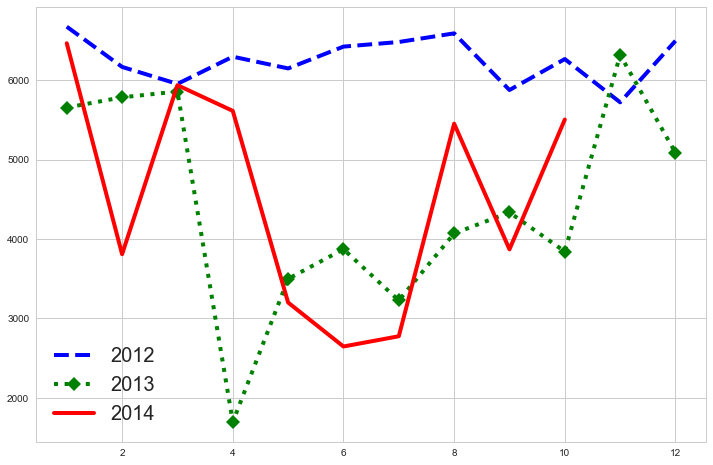

In [8]:
show_tendency(2)

위 plot은 2번 store에서의 units경향이다.

2013년과 2014년에서 units가 떨어진 것으로 보아, 

이 시점에서의 weather를 비교해보면 뭔가 insight를 얻을 수 있지 않을까, 그래서 해당 store에서 item_nbr는 뭐가 팔렸고 얼마나 팔렸는지 찍어봤다

### 1. 1. 2.  `year`, `month`, `store_nbr` vs `units`

In [9]:
def item_nbr_tendency(store_nbr):
    '''
    input : store_nbr
    output : graph representing units groupped by each year, each month
    '''
    store = df_tmp[df_tmp['store_nbr'] == store_nbr]

    pivot = store.pivot_table(index=['year','month'],columns='item_nbr',values='units',aggfunc=np.sum)
    zero_index = pivot==0
    pivot = pivot[pivot!=0].dropna(axis=1,how='all')
    pivot[zero_index]=0
    
    
    pivot_2012 = pivot.loc[2012]
    pivot_2013 = pivot.loc[2013]
    pivot_2014 = pivot.loc[2014]
    
    plt.figure(figsize=(12,8))
    plt.subplot(131)
    sns.heatmap(pivot_2012,cmap="YlGnBu", annot = True, fmt = '.0f')
    plt.subplot(132)
    sns.heatmap(pivot_2013,cmap="YlGnBu", annot = True, fmt = '.0f')
    plt.subplot(133)
    sns.heatmap(pivot_2014,cmap="YlGnBu", annot = True, fmt = '.0f')
    plt.show()

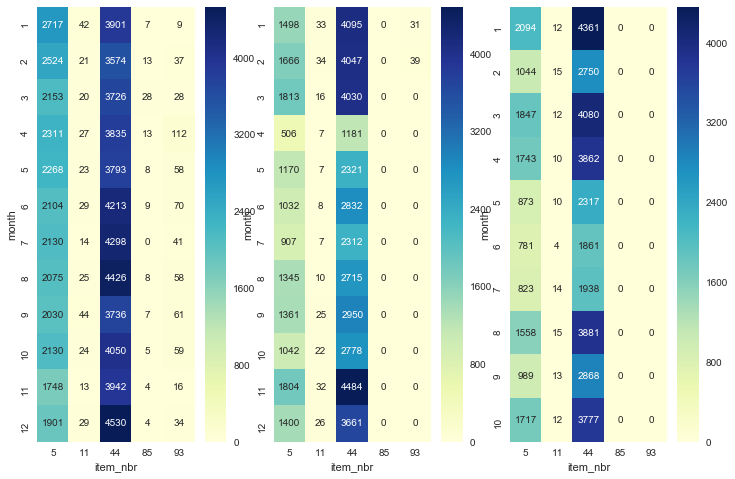

In [10]:
item_nbr_tendency(2)

위 plot은 해당 store에서 한번이라도 팔린 item에 대한 units를 year, month별로 출력한 것이다.

어떤 item_nbr의 units가 떨어졌는지 확인할 순 있지만 month별로 출력했기 때문에 각 day별로는 확인할 수 없다.

day별로 확인할 수 없다면 weather feature가 각 날짜에 얼마나 영향을 미쳤는지 정확히 조사할 수 없다.

따라서 day별로 plot을 찍어봤다

### 1. 1. 3.  `year`, `month`, `day`, `store_nbr`, `item_nbr` vs `units`

In [11]:
def item_nbr_tendency_finely(store_nbr, year, month_start=-1, month_end=-1, graph=True):
    '''
    input
        1. store_nbr = 스토어 번호
        2. year = 연도
        3. month_start = 시작달
        4. month_start = 끝달
        5. graph = 위의 정보에 대한 item_nbr 그래프 출력여부
    
    output
        1. store_nbr, year, month로 filtering한 item_nbr의 pivot 테이블
    '''
    store = df_tmp[(df_tmp['store_nbr'] == store_nbr) & (df_tmp['year'] == year)]

    if month_start != -1:
        if month_end == -1:
            month_end = month_start + 1
        store = store[(month_start <= store['month']) & (store['month'] < month_end)]

    pivot = store.pivot_table(index='item_nbr',
                              columns='date',
                              values='units',
                              aggfunc=np.sum)

    zero_index = pivot == 0
    pivot = pivot[pivot != 0].dropna(axis=0, how='all')
    pivot[zero_index] = 0

    if graph:
        plt.figure(figsize=(12, 8))
        sns.heatmap(pivot, cmap="YlGnBu", annot=True, fmt='.0f')
        plt.show()

    return pivot

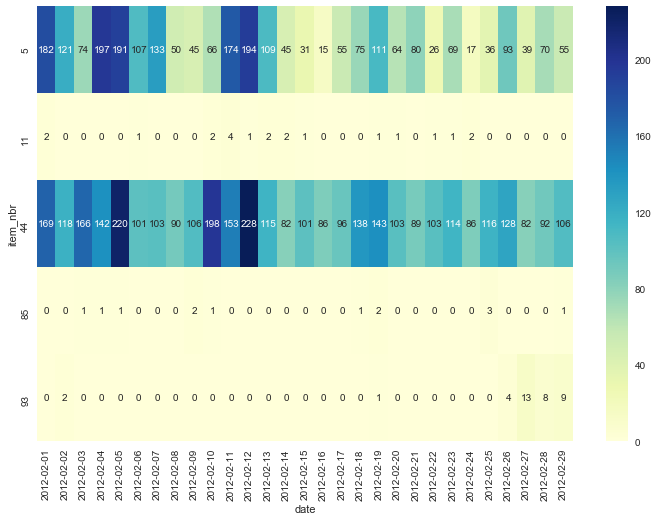

date,2012-02-01,2012-02-02,2012-02-03,2012-02-04,2012-02-05,2012-02-06,2012-02-07,2012-02-08,2012-02-09,2012-02-10,...,2012-02-20,2012-02-21,2012-02-22,2012-02-23,2012-02-24,2012-02-25,2012-02-26,2012-02-27,2012-02-28,2012-02-29
item_nbr,,,,,,,,,,,,,,,,,,,,,
5,182.0,121.0,74.0,197.0,191.0,107.0,133.0,50.0,45.0,66.0,...,64.0,80.0,26.0,69.0,17.0,36.0,93.0,39.0,70.0,55.0
11,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,...,1.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0
44,169.0,118.0,166.0,142.0,220.0,101.0,103.0,90.0,106.0,198.0,...,103.0,89.0,103.0,114.0,86.0,116.0,128.0,82.0,92.0,106.0
85,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0
93,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,13.0,8.0,9.0


In [12]:
item_nbr_tendency_finely(2,2012,2)

각 day별로 해당 item_nbr와 date, units를 pivot하여 찍은 plot이다.

각 날짜에 어떤 units변화가 일어났는지 weather와 같이 비교해볼 수 있는 형태가 됬고, 아래의 plot은 위와 똑같은 기간의 weather 데이터다.




In [13]:
def weather_tendency(store_nbr, year, month_start = -1, month_end = -1):
    
    store = df_tmp[(df_tmp['store_nbr'] == store_nbr) & (df_tmp['year'] == year)]
    
    if month_start!=-1:
        if month_end == -1:
            month_end = month_start + 1
        store = store[(month_start <= store['month']) & (store['month'] < month_end)]
    
    store = store.drop(labels=['item_nbr','units'],axis=1)
    store = store.drop_duplicates(keep='first').reset_index(drop=True)
    store.index.name='date'
    store.index = store['date']
        
    return store

In [14]:
weather_tendency(2,2012).head()

,station_nbr,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,store_nbr,year,month
date,,,,,,,,,,,,,,,,,,,,,
2012-01-01,14,2012-01-01,50,34,42,5,25,35,23,0,...,0.0,0.00,29.13,30.52,11.4,32,11.3,2,2012,1
2012-01-02,14,2012-01-02,45,26,36,-1,16,29,29,0,...,0.0,0.00,29.21,30.65,6.3,35,7.4,2,2012,1
2012-01-03,14,2012-01-03,60,24,42,5,23,33,23,0,...,0.0,0.00,28.84,30.30,12.4,18,12.7,2,2012,1
2012-01-04,14,2012-01-04,58,32,45,9,27,37,20,0,...,0.0,0.00,28.89,30.29,6.1,34,7.6,2,2012,1
2012-01-05,14,2012-01-05,67,29,48,12,28,38,17,0,...,0.0,0.00,28.71,30.14,9.8,21,10.3,2,2012,1


units의 변화량에 대해 각 날짜별로 비교할 수 있지만, 

일일이 비교해서 유의미한 insight를 도출하기엔 비현실적이다.

그래서 아래와 같이 입력받은 스토어에 대해서,

모든 item_nbr에 대한 weather feature VS units의 피어슨 상관계수를 구한 것이 아래다

In [15]:
def get_correlation(store_nbr, year, month_start=-1, month_end=-1):
    '''
    input:
        위와 같음
    output:
        missing, tracing data를 제외한
        팔린 item_nbr별 각 weather feature에 대한 pearsonr, pvalue를 담은 dictionary
    '''

    '''
    Use-case
        1. 7번 store, 2012년 1월부터 12월까지 item_nbr별 상관관계를 알고 싶다
        get_correlation(7,2012)
        
        2. 7번 store, 2012년 1월부터 3월까지 item_nbr별 상관관계를 알고 싶다
        get_correlation(7,2012,1,3)
        
        3. 7번 store, 2012년 5월만 item_nbr별 상관관계를 알고 싶다
        get_correlation(7,2012,5)
    '''
    correlation = dict()

    units_table = item_nbr_tendency_finely(store_nbr, year, month_start, month_end, graph=False)
    weather_table = weather_tendency(store_nbr, year, month_start, month_end)

    weather = list(weather_table.columns[3:20])
    weather.remove('codesum')

    item_nbr = units_table.index

    inner = dict()

    for feature in weather:
        for units in item_nbr:

            a = weather_table[feature].copy()
            b = units_table.loc[units].copy()

            a = a.apply(lambda x: x.replace(' ', ''))
            a = a.apply(lambda x: x.replace('-', ''))

            missing_index = (a.str.contains('M')) | (a.str.contains('T'))
            nothing_index = a.apply(lambda x: len(x)) == 0

            a[missing_index] = np.nan
            b[missing_index] = np.nan

            a[nothing_index] = np.nan
            b[nothing_index] = np.nan
            
            a.dropna(axis=0, inplace=True)
            b.dropna(axis=0, inplace=True)

            inner[(units, feature, len(a))] = sp.stats.pearsonr(a.astype(float), b)

            correlation[(store_nbr, year, month_start, month_end-1)] = inner

    return correlation


def show_me_pearson(pearson_dict):

    for key,val in pearson_dict.items():
        print(key, '\n')
        
        if isinstance(val,dict):
            printee = []
            keys = list(val.keys())
            keys.sort()
            printee += [(k,val[k]) for k in keys]
        
        else:
            printee = val
        
        for each in printee:
            print('\t',each)
            
            
def trim_correlation(correlation_dict):

    keys = correlation_dict.keys()
    result = dict()
    
    for key in keys:
        inner_dict = correlation_dict[key]
        item_nbrs = list(set(each[0] for each in inner_dict.keys()))
        sorted_filtered = filter_sort_inner_dict(inner_dict, item_nbrs)
        
        result[key] = sorted_filtered
        
    return result  


def filter_sort_inner_dict(inner_dict, item_nbrs):

    pvalue_filtered = [(key,val) for key,val in inner_dict.items() if val[1] < 0.01]
    pearsonr_sorted = []
    
    for item_nbr in item_nbrs:
        pearsonr_sorted += sort_inner_dict(item_nbr,pvalue_filtered)
    
    return pearsonr_sorted


def sort_inner_dict(item_nbr, filtered):

    each_item = [each for each in filtered if each[0][0]==item_nbr]
    each_item = sorted(each_item, key = lambda each: abs(each[1][0]), reverse=True)
    
    return each_item

In [16]:
show_me_pearson(trim_correlation(get_correlation(1,2012)))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:2998: RuntimeWarning: Mean of empty slice.
  mx = x.mean()
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:2999: RuntimeWarning: Mean of empty slice.
  my = y.mean()
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


(1, 2012, -1, -2) 

	 ((99, 'cool', 362), (0.23360735334567914, 7.0686857495894558e-06))
	 ((99, 'wetbulb', 360), (0.22639519766547406, 1.4440842669249175e-05))
	 ((99, 'dewpoint', 363), (0.22037814773777978, 2.2704690497583713e-05))
	 ((99, 'tmin', 364), (0.21596943064827212, 3.2471288574920153e-05))
	 ((99, 'tavg', 362), (0.21407692268563641, 4.0133159063757517e-05))
	 ((99, 'heat', 362), (-0.18171028709217207, 0.00051221897840355245))
	 ((40, 'heat', 362), (0.34992110266857479, 7.2561712206726976e-12))
	 ((40, 'tavg', 362), (-0.33489777191229109, 6.1673670092993148e-11))
	 ((40, 'tmin', 364), (-0.30542826661212402, 2.6825967727965087e-09))
	 ((40, 'wetbulb', 360), (-0.29821823918217327, 7.9065225532450263e-09))
	 ((40, 'dewpoint', 363), (-0.25763556532294596, 6.4933384743597965e-07))
	 ((40, 'cool', 362), (-0.17878773214082763, 0.00063203918882930282))
	 ((9, 'heat', 362), (0.19621037229892041, 0.00017208151618507012))
	 ((9, 'tavg', 362), (-0.17774820347368961, 0.000680579322241266

### 1. 1. 4.  `codesum` 발생 여부 vs `units`

In [17]:
def show_codesum_vs_units(station_nbr):

    # create new column 'codesum_YN' : 'Ab' as codesum occured, 'Mo' as moderate weather
    def codesum_YN(codesum):
        if codesum == "moderate":
            return "Mo"
        else:
            return "Ab"
    df_tmp['codesum_YN'] = df_tmp['codesum'].apply(codesum_YN)

    # show only rows with units sales occured
    df_tmp_2 = df_tmp[df_tmp['units'] > 0].reset_index(drop=True)
    
    # caculate sales difference between codesum vs no codesum in percentage
    pivot_data = df_tmp_2.pivot_table(index=['station_nbr', 'item_nbr'],columns=['codesum_YN'],values='units', aggfunc='sum')
    pivot_data['Difference(%)'] = ((pivot_data['Ab'] - pivot_data['Mo']) / pivot_data['Mo'] * 100).round(2)
    pivot_data.drop(columns=['Ab', 'Mo'], inplace=True)
    station = pivot_data.loc[station_nbr]
    station = station.reset_index(drop=False)
    
    # seaborn barplot
    fig = plt.figure(figsize=(20, 6))
    sns.barplot(x='item_nbr', y='Difference(%)', data=station)
    plt.show()

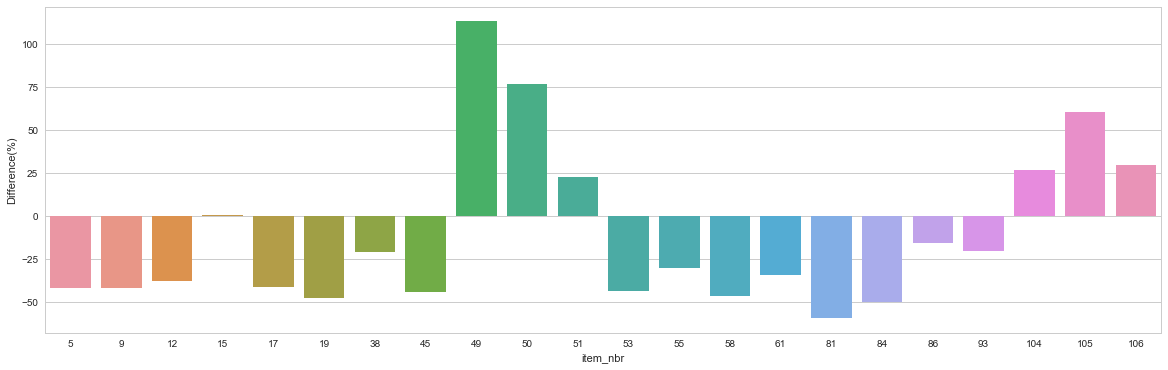

In [18]:
show_codesum_vs_units(13)

### 1. 1. 5. `holiday`  vs `units`

#### Add new column `dayofweek`

In [19]:
def make_year(date):
    return int(date.split('-')[0])
def make_month(date):
    return int(date.split('-')[1])
def make_day(date):
    return int(date.split('-')[2])
def make_monthday(date):
    return (date.split('-')[1:3])

In [20]:
def is_leap_year(year):
    return ((year % 4 == 0 and year % 100 != 0) or year % 400 == 0)

def sum_of_days(year,monthday):
    
    month = int(monthday[0])
    day = int(monthday[1])
    
    common_year = [
        31,
        28 + + int(is_leap_year(year)),
        31,
        30,
        31,
        30,
        31,
        31,
        30,
        31,
        30,
        31
    ]
    tmp_days = 0
    for i in range(month - 1):
        tmp_days += common_year[i]
    tmp_days += day
    return tmp_days

In [21]:
# 요일 구하는 함수
def check_week_of_day(year,days):
    
    if year == 2012:
        date_list = ['Sun', 'Mon', 'Tue', 'Wed', 'Thi', 'Fri', 'Sat']
        
    elif year == 2013:
        date_list = ['Tue', 'Wed', 'Thi', 'Fri', 'Sat', 'Sun', 'Mon']
    
    else:
        date_list = ['Wed', 'Thi', 'Fri', 'Sat', 'Sun', 'Mon','Tue']
    
    return date_list[days % 7 - 1]

In [22]:
weather_1['year'] = weather_1['date'].apply(make_year)
weather_1['month'] = weather_1['date'].apply(make_month)
weather_1['day'] = weather_1['date'].apply(make_day)
weather_1['monthday'] = weather_1['date'].apply(make_monthday)
weather_1['days'] = weather_1.apply(lambda row : sum_of_days(row['year'], row['monthday']), axis = 1)
weather_1['dayofweek'] = weather_1.apply(lambda row : check_week_of_day(row['year'], row['days']), axis = 1)

#### Add new column `holiday`

In [23]:
def is_holiday(dayofweek):
    if dayofweek == "Sun" or dayofweek == "Sat":
        return 'weekend'
    else:
        return 'workday'

In [24]:
weather_1['weekend_YN'] = weather_1['dayofweek'].apply(is_holiday)

In [25]:
weather_1.tail()

,station_nbr,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,resultspeed,resultdir,avgspeed,year,month,day,monthday,days,dayofweek,weekend_YN
20512,16,2014-10-31,53,34,44,M,35,41,21,0,...,4.5,03,5.3,2014,10,31,"[10, 31]",304,Fri,workday
20513,17,2014-10-31,59,34,47,M,32,41,18,0,...,9.2,01,9.3,2014,10,31,"[10, 31]",304,Fri,workday
20514,18,2014-10-31,67,49,58,-4,40,50,7,0,...,10.6,36,11.2,2014,10,31,"[10, 31]",304,Fri,workday
20515,19,2014-10-31,45,33,39,-6,24,32,26,0,...,20.4,34,20.9,2014,10,31,"[10, 31]",304,Fri,workday
20516,20,2014-10-31,68,50,59,M,39,50,6,0,...,10.5,36,11.2,2014,10,31,"[10, 31]",304,Fri,workday


In [26]:
weather_1.to_csv('./data/add_holiday_weather.csv', sep = ',')

#### 위에서 저장한 오로지 팔린 item_nbr에 대한 데이터만 필터

- dayofweek : 요일
- holiday : 휴일 여부

In [27]:
df_tmp2 = pd.merge(train_key, weather_1)
df_tmp2 = df_tmp2[df_tmp2['units'] != 0]
df_tmp2 = df_tmp2.loc[:,['date', 'station_nbr', 'store_nbr', 'item_nbr', 'units', 'dayofweek', 'weekend_YN']]

In [28]:
df_tmp2.to_csv('./data/check_for_holiday_and_units.csv', sep = ',')

Pivot Table & Heatmap
- index 는 store > 팔린 품목
- columns 는 holiday, workday
- values = 3년간 sales의 평균

In [29]:
df_tmp2 = pd.read_csv('data/check_for_holiday_and_units.csv', index_col = 0)

In [30]:
pivot_data = df_tmp2.pivot_table(values = 'units', index = ['store_nbr','item_nbr'], columns=['weekend_YN']).fillna(value = 0).astype(int)

In [35]:
def check_heatmap_holiday(nbr):
    store_nbr = pivot_data.loc[nbr]
    fig = plt.figure(figsize=(25, 10))
    sns.heatmap(store_nbr, cmap="YlGnBu", annot = True, fmt = '.0f')

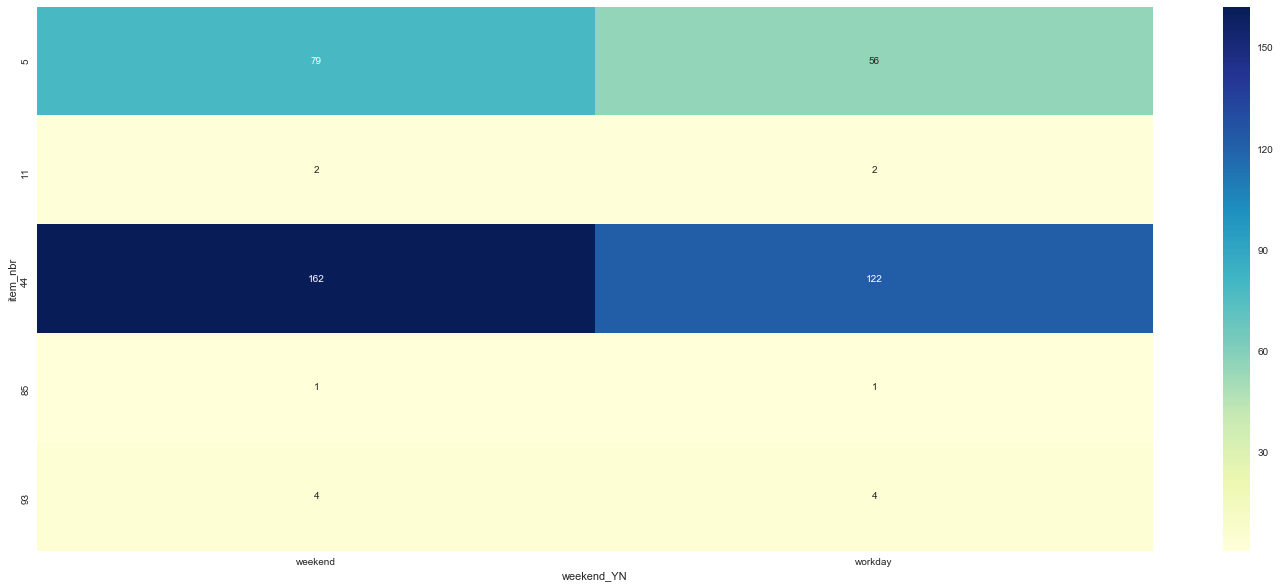

In [36]:
check_heatmap_holiday(2)

#### 특정 인기품목에 대해서는 주중에 비해 휴일이 sales가 높았던 것을 눈으로 확인할 수 있었습니다.
- 모델링할 때 휴일과 주중에 대한 컬럼변수도 고려할 수 있었다.

# 1. 2. Identify Missing Data

## 1. 2. 1. Transform all missing data into `np.nan`

In [37]:
for i in weather_1.columns:
    print(i, "\n", weather_1[i].unique())

station_nbr 
 [ 1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20  5]
date 
 ['2012-01-01' '2012-01-02' '2012-01-03' ..., '2014-10-29' '2014-10-30'
 '2014-10-31']
tmax 
 ['52' '48' '55' '63' '50' '66' '34' '73' '72' '38' '56' '59' '46' '45' '60'
 '44' '21' '65' '43' '53' '25' '32' '28' '62' '61' '47' '30' '26' '71' '58'
 '39' '54' '23' '27' '31' '68' '70' '67' '36' '69' '74' '75' '33' '51' '57'
 '41' '49' '76' '35' '77' '64' '40' '16' '37' '42' '14' '22' '13' '10' '20'
 '24' '80' '4' '11' '78' '17' '18' '79' '29' '81' '82' '83' '88' '87' '92'
 '89' '84' '85' '86' '90' '91' '94' '93' '96' '95' 'M' '97' '98' '101' '99'
 '100' '105' '103' '102' '106' '104' '109' '107' '108' '110' '111' '112'
 '114' '113' '19' '15' '12' '-1' '5' '8' '9' '1' '6' '2' '3' '7' '-2' '-11'
 '-4' '-6' '0']
tmin 
 ['31' '33' '34' '47' '45' '19' '53' '48' '18' '26' '30' '38' '40' '25' '41'
 '28' '24' '37' '36' '11' '16' '29' '22' '35' '15' '9' '21' '27' '10' '5'
 '32' '20' '3' '8' '44' '46' '17' '55' '43' '57

TypeError: unhashable type: 'list'

### Types of Missing Data : ` - `, ` M `, ` T `, `  T`, `(blank)`

In [38]:
for i in weather_1.columns:
    weather_1[i] = weather_1[i].replace('-', np.nan)
    weather_1[i] = weather_1[i].replace(' ', np.nan)
    weather_1[i] = weather_1[i].replace('M', np.nan)
    weather_1[i] = weather_1[i].replace('T', np.nan)
    weather_1[i] = weather_1[i].replace('  T', np.nan)

## 1. 2. 2. Visualize Missing Data

### 1. 2. 2. 1. All

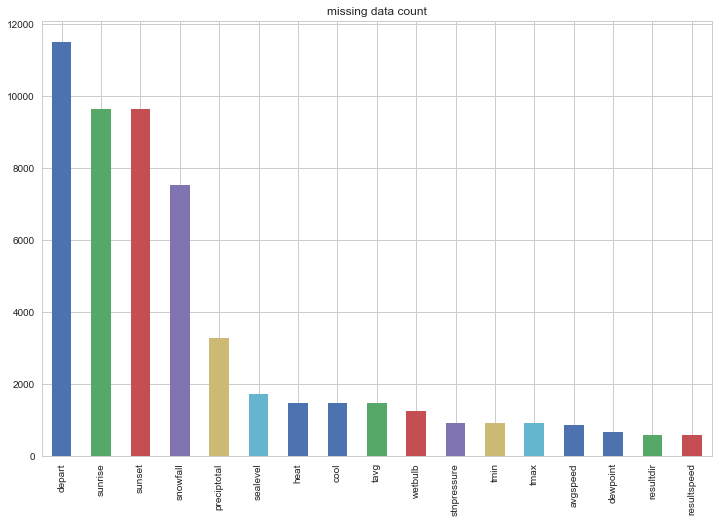

In [39]:
plt.figure(figsize=(12,8))
count_null = weather_1.isnull().sum()
count_null.sort_values(ascending = False, inplace = True)
count_null = count_null[count_null > 0]
count_null.plot(kind = 'bar', title = 'missing data count')
plt.show()

### 1. 2. 2. 2. Missing Data by each Station

In [40]:
def station_null(station_nbr):
    print("Total data size of station_" + str(station_nbr) + " : " + str(len(weather_1[weather_1['station_nbr'].isin([5])])))
    
    plt.figure(figsize=(16,4))
    count_null = weather_1[weather_1['station_nbr'].isin([station_nbr])].isnull().sum()
    count_null.sort_values(ascending = False, inplace = True)
    count_null = count_null[count_null > 0]
    count_null.plot(kind = 'bar', title = 'missing data count')
    plt.show()

Total data size of station_5 : 852


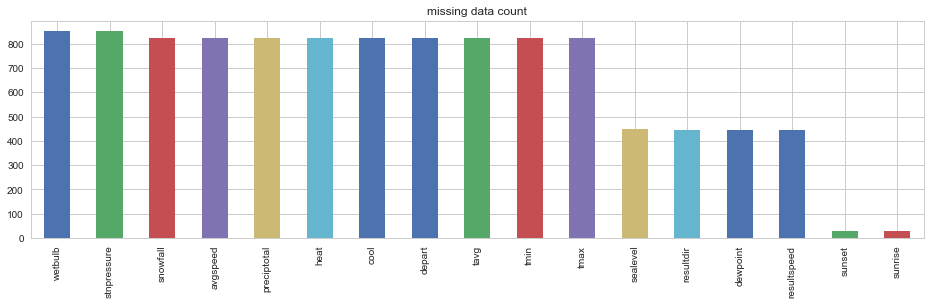

In [41]:
station_null(5)

# 2. Preprocessing

## 2. 1. Weather : Missing data imputation

모델링하기 전에 데이터의 복원에 대해서 고려해야 했다.  
missing value가 발행하지 않은 데이터만 가지고 modeling을 할 수는 없다

1. OLS가 안 돌아간다.
2. 완전한 데이터만 걸렀을 때는 
    - 빠져버리는 store가 발생한다.
    - missing data가 하나도 없는 데이터는 7000개 뿐이다.
    - 제공받은 데이터 중 완전한 데이터, 즉 일부만 사용한다면 편향된 결과를 도출할 수 있다.

---------------

### Weather 데이터의 Imputation을 위한 3가지 방법 도출

>#### 1. _Yesterday_ : 어제 날짜를 참조하여 복원

>#### 2. _Mean_ : 해당 station의 해당 feature의 평균으로 복원

>#### 3. _Closest_ : missing 행과 가장 비슷한 행을 찾아 복원

--------------------------

### 2. 1. 1. Weather data imputation : _Closest_ method

(최종적으로 결과가 좋았던 , best_close 방식으로 설명)

1. 전체 station에서 missing value가 하나도 없는 intact row들을 뽑음
2. 모든 intact한 row를 고려하면 시간이 오래 걸리므로 DataFrame.sample함수를 이용하여 랜덤하게 추출
3. missing이 발생한 행에 대해서 intact한 row와 가장 가까운 행을 찾음
4. 이 때 기준은 각 feature의 Z-score (모든 feature를 공평하게 반영하여 가까운 행을 찾음)
5. 이 Z-score의 차이가 가장 적은 행이 가장 가까운 행이다.

### 2. 1. 2. Merge all imputed weather data

In [42]:
from functools import reduce

each_station = []

for station_nbr in range(1,21):
    file_path = 'data/weather_imputation_v3/{:02}.csv'.format(station_nbr)
    station = pd.read_csv(file_path,index_col=0)
    station.dropna(axis=0,how='any',inplace=True)
    each_station.append(station)

weather = reduce((lambda x,y : x.append(y)),each_station)

In [43]:
weather = weather.reset_index(drop=True)
print(weather.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20512 entries, 0 to 20511
Data columns (total 23 columns):
station_nbr    20512 non-null int64
date           20512 non-null object
tmax           20512 non-null float64
tmin           20512 non-null float64
tavg           20512 non-null float64
depart         20512 non-null float64
dewpoint       20512 non-null float64
wetbulb        20512 non-null float64
heat           20512 non-null float64
cool           20512 non-null float64
sunrise        20512 non-null float64
sunset         20512 non-null float64
snowfall       20512 non-null float64
preciptotal    20512 non-null float64
stnpressure    20512 non-null float64
sealevel       20512 non-null float64
resultspeed    20512 non-null float64
resultdir      20512 non-null float64
avgspeed       20512 non-null float64
year           20512 non-null int64
month          20512 non-null int64
day            20512 non-null int64
codesum        20512 non-null object
dtypes: float64(17), int64(

## 2. 2. Encoding

### 2. 2. 1. `date` 

In [44]:
weather['year'] = weather['date'].apply(make_year)
weather['month'] = weather['date'].apply(make_month)
weather['day'] = weather['date'].apply(make_day)
weather['monthday'] = weather['date'].apply(make_monthday)
weather['days'] = weather.apply(lambda row : sum_of_days(row['year'], row['monthday']), axis = 1)
weather['dayofweek'] = weather.apply(lambda row : check_week_of_day(row['year'], row['days']), axis = 1)
weather['weekend_YN'] = weather['dayofweek'].apply(is_holiday)

In [45]:
weather

,station_nbr,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,resultdir,avgspeed,year,month,day,codesum,monthday,days,dayofweek,weekend_YN
0,1,2012-01-01,52.0,31.0,42.0,10.0,36.0,40.0,23.0,0.0,...,20.0,4.6,2012,1,1,RA FZFG BR,"[01, 01]",1,Sun,weekend
1,1,2012-01-02,50.0,31.0,41.0,23.0,26.0,35.0,24.0,0.0,...,24.0,10.3,2012,1,2,,"[01, 02]",2,Mon,workday
2,1,2012-01-03,32.0,11.0,22.0,2.0,4.0,18.0,43.0,0.0,...,31.0,11.6,2012,1,3,,"[01, 03]",3,Tue,workday
3,1,2012-01-04,28.0,9.0,19.0,15.0,1.0,14.0,46.0,0.0,...,27.0,8.3,2012,1,4,,"[01, 04]",4,Wed,workday
4,1,2012-01-05,38.0,25.0,32.0,7.0,13.0,25.0,33.0,0.0,...,25.0,7.8,2012,1,5,,"[01, 05]",5,Thi,workday
5,1,2012-01-06,46.0,25.0,36.0,8.0,21.0,29.0,29.0,0.0,...,1.0,2.4,2012,1,6,SN,"[01, 06]",6,Fri,workday
6,1,2012-01-07,57.0,28.0,43.0,10.0,28.0,36.0,22.0,0.0,...,26.0,3.6,2012,1,7,,"[01, 07]",7,Sat,weekend
7,1,2012-01-08,45.0,27.0,36.0,10.0,22.0,32.0,29.0,0.0,...,30.0,6.6,2012,1,8,,"[01, 08]",8,Sun,weekend
8,1,2012-01-09,39.0,23.0,31.0,8.0,12.0,25.0,34.0,0.0,...,23.0,4.0,2012,1,9,,"[01, 09]",9,Mon,workday
9,1,2012-01-10,47.0,29.0,38.0,10.0,24.0,32.0,27.0,0.0,...,25.0,6.5,2012,1,10,,"[01, 10]",10,Tue,workday


### 2. 2. 2. ` codesum `

#### 2. 2. 2. 1. Adding new column : `codesum_YN`

In [46]:
def codesum_YN(codesum):
    if codesum == " ":
        return 0 # as moderate
    else:
        return 1 # as codesum occured

In [47]:
weather['codesum_YN'] = weather['codesum'].apply(codesum_YN)

#### 2. 2. 2. 1. `codesum` by frequency

#### codesum 발생 빈도
- 'BC': 111,
- 'BL': 59,
- 'BR': 6359,
- 'DU': 28,
- 'DZ': 497,
- 'FG': 1307,
- 'FU': 33,
- 'FZ': 332,
- 'GR': 3,
- 'GS': 5,
- 'HZ': 1482,
- 'MI': 52,
- 'MO': 11051,
- 'PL': 20,
- 'PR': 1,
- 'RA': 5325,
- 'SG': 1,
- 'SN': 1008,
- 'SQ': 14,
- 'TS': 1888,
- 'UP': 230,
- 'VC': 571

#### 전처리 방식:
- 예를 들어 `RA,FG,FZ,BR` 이라는 코드섬이 있다면 `5325, 1307, 332, 6359` 로 변환 후
- 가장 높은 수를 가진 2개의 코드섬으로 변환 즉 `BR,RA`로 변환

In [48]:
# handling이 쉽도록 깔금하게 정리하는 코드
def ch_codesum(codesum):
    result = ""
    
    codesum = codesum.replace(" ","")
    codesum = codesum.replace("+","")
    
    for s in range(0,len(codesum)):
        if s % 2 == 0 and s != 0:
            result += ',' + codesum[s]
        else:
            result += codesum[s]
    return result

In [49]:
weather_tmp = pd.read_csv('./data/weather.csv', index_col = 0)
weather_tmp = weather.reset_index()

# 코드섬 카테고리작업을 위한 copy
weather_2 = weather.copy()
weather_2 = weather_2.loc[:,['date','codesum']]

# 함수적용
weather_2['codesum'] = weather_2['codesum'].apply(codesum_moderate)
weather_2['codesum'] = weather_2['codesum'].apply(ch_codesum)

from collections import Counter
codesum_list = list(weather_2['codesum'])
print(codesum_list[:10])

['RA,FZ,FG,BR', 'mo,de,ra,te', 'mo,de,ra,te', 'mo,de,ra,te', 'mo,de,ra,te', 'SN', 'mo,de,ra,te', 'mo,de,ra,te', 'mo,de,ra,te', 'mo,de,ra,te']


In [50]:
code_list = []
for i in codesum_list:
    i = list(set(i.split(',')))
    for j in i:
        code_list.append(j)
        
counts_code = dict(Counter(code_list))
print(counts_code)

{'FZ': 332, 'BR': 6358, 'RA': 5324, 'FG': 1307, 'ra': 11047, 'te': 11047, 'mo': 11047, 'de': 11047, 'SN': 1008, 'UP': 230, 'HZ': 1482, 'TS': 1888, 'VC': 571, 'BL': 59, 'DZ': 497, 'DU': 28, 'BC': 111, 'FU': 33, 'PL': 20, 'MI': 52, 'SQ': 14, 'GR': 3, 'GS': 5, 'SG': 1, 'PR': 1}


#### Select Top_2 frequent codesum

In [51]:
def codesum_two(codesum):
    codesum = codesum.split(',')
    if len(codesum) >= 2:
        tmp_code = []
        tmp_list = list(set([counts_code[code] for code in codesum]))
        tmp_list.sort()
        tmp_list.reverse()
        top2_code = tmp_list[:2]
        for idx,val in counts_code.items():
            if val in top2_code:
                tmp_code.append(idx)
            else:
                continue
        return ",".join(tmp_code)
    return ",".join(codesum)

In [52]:
weather_2['codesum'] = weather_2['codesum'].apply(codesum_two)

counts_codesum_set = dict(Counter(weather_2['codesum']))

sum_percentage = 0
for idx,val in counts_codesum_set.items():
    
    if val > 1000:
        percentage = round((val / 20517) * 100,2)
        print(idx," "*(12 - len(idx)),val," "*(7 - len(str(val))),str(percentage)+"%")
        sum_percentage += percentage
            
print("-------total_percentage---------")
print(str(sum_percentage) + "%")

BR,RA         3311     16.14%
ra,te,mo,de   11047    53.84%
RA            1281     6.24%
BR            1431     6.97%
-------total_percentage---------
83.19%


#### Other codesums as `AN`

In [53]:
def convert_codesum(codesum):
    if codesum == "BR" or codesum == "RA" or codesum == "BR,RA" or codesum == "MO":
        return codesum
    else:
        return "AN"

In [54]:
weather_2['codesum'] = weather_2['codesum'].apply(convert_codesum)
weather_2['codesum'].unique()

array(['BR,RA', 'AN', 'RA', 'BR'], dtype=object)

#### Replace with `codesum` column

In [55]:
del weather['codesum']
weather['codesum'] = weather_2['codesum']

In [56]:
weather['codesum'].unique()

array(['BR,RA', 'AN', 'RA', 'BR'], dtype=object)

In [57]:
print(weather.shape)
weather

(20512, 28)


,station_nbr,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,avgspeed,year,month,day,monthday,days,dayofweek,weekend_YN,codesum_YN,codesum
0,1,2012-01-01,52.0,31.0,42.0,10.0,36.0,40.0,23.0,0.0,...,4.6,2012,1,1,"[01, 01]",1,Sun,weekend,1,"BR,RA"
1,1,2012-01-02,50.0,31.0,41.0,23.0,26.0,35.0,24.0,0.0,...,10.3,2012,1,2,"[01, 02]",2,Mon,workday,0,AN
2,1,2012-01-03,32.0,11.0,22.0,2.0,4.0,18.0,43.0,0.0,...,11.6,2012,1,3,"[01, 03]",3,Tue,workday,0,AN
3,1,2012-01-04,28.0,9.0,19.0,15.0,1.0,14.0,46.0,0.0,...,8.3,2012,1,4,"[01, 04]",4,Wed,workday,0,AN
4,1,2012-01-05,38.0,25.0,32.0,7.0,13.0,25.0,33.0,0.0,...,7.8,2012,1,5,"[01, 05]",5,Thi,workday,0,AN
5,1,2012-01-06,46.0,25.0,36.0,8.0,21.0,29.0,29.0,0.0,...,2.4,2012,1,6,"[01, 06]",6,Fri,workday,1,AN
6,1,2012-01-07,57.0,28.0,43.0,10.0,28.0,36.0,22.0,0.0,...,3.6,2012,1,7,"[01, 07]",7,Sat,weekend,0,AN
7,1,2012-01-08,45.0,27.0,36.0,10.0,22.0,32.0,29.0,0.0,...,6.6,2012,1,8,"[01, 08]",8,Sun,weekend,0,AN
8,1,2012-01-09,39.0,23.0,31.0,8.0,12.0,25.0,34.0,0.0,...,4.0,2012,1,9,"[01, 09]",9,Mon,workday,0,AN
9,1,2012-01-10,47.0,29.0,38.0,10.0,24.0,32.0,27.0,0.0,...,6.5,2012,1,10,"[01, 10]",10,Tue,workday,0,AN


#### 2. 3. 2. 1. Final Merge : 

In [58]:
df = pd.merge(train_key, weather)
print(df.shape)
df.head()

(4616490, 31)


,store_nbr,station_nbr,date,item_nbr,units,tmax,tmin,tavg,depart,dewpoint,...,avgspeed,year,month,day,monthday,days,dayofweek,weekend_YN,codesum_YN,codesum
0,1,1,2012-01-01,1,0,52.0,31.0,42.0,10.0,36.0,...,4.6,2012,1,1,"[01, 01]",1,Sun,weekend,1,"BR,RA"
1,1,1,2012-01-01,2,0,52.0,31.0,42.0,10.0,36.0,...,4.6,2012,1,1,"[01, 01]",1,Sun,weekend,1,"BR,RA"
2,1,1,2012-01-01,3,0,52.0,31.0,42.0,10.0,36.0,...,4.6,2012,1,1,"[01, 01]",1,Sun,weekend,1,"BR,RA"
3,1,1,2012-01-01,4,0,52.0,31.0,42.0,10.0,36.0,...,4.6,2012,1,1,"[01, 01]",1,Sun,weekend,1,"BR,RA"
4,1,1,2012-01-01,5,0,52.0,31.0,42.0,10.0,36.0,...,4.6,2012,1,1,"[01, 01]",1,Sun,weekend,1,"BR,RA"


# 3. OLS 모델링

### 변수 : 
- 종속변수 : `units`
- 독립변수 : weather features, date

### Condition :
- 판매가 이루어진 data에 한해 분석을 한다.
- `units`= 0 인 데이터는 제외한다. 

In [59]:
df_test = df[df['units'] != 0]
print(df_test.shape)
df_test.head()

(118664, 31)


,store_nbr,station_nbr,date,item_nbr,units,tmax,tmin,tavg,depart,dewpoint,...,avgspeed,year,month,day,monthday,days,dayofweek,weekend_YN,codesum_YN,codesum
8,1,1,2012-01-01,9,29,52.0,31.0,42.0,10.0,36.0,...,4.6,2012,1,1,"[01, 01]",1,Sun,weekend,1,"BR,RA"
27,1,1,2012-01-01,28,2,52.0,31.0,42.0,10.0,36.0,...,4.6,2012,1,1,"[01, 01]",1,Sun,weekend,1,"BR,RA"
50,1,1,2012-01-01,51,1,52.0,31.0,42.0,10.0,36.0,...,4.6,2012,1,1,"[01, 01]",1,Sun,weekend,1,"BR,RA"
119,1,1,2012-01-02,9,60,50.0,31.0,41.0,23.0,26.0,...,10.3,2012,1,2,"[01, 02]",2,Mon,workday,0,AN
138,1,1,2012-01-02,28,5,50.0,31.0,41.0,23.0,26.0,...,10.3,2012,1,2,"[01, 02]",2,Mon,workday,0,AN


### 두번째 경우
얘는 script임. 발표할 때 따로 어디다 적어놓고 읽을 것
1. 카테고리로 store_nbr, item_nbr를 줬을 때 알스퀘어값이 0.6정도 나옴.

2. 이 상태에서 복원한 각 버전으로 아웃라이어 제거, VIF로 다중공선성 제거, 각 실수 독립변수에 대해 scaling, 변수변환으로 각각 모델링 시행.

3. 독립변수에 몇가지를 더 추가하여 트레이닝한 결과 평균적으로 알스퀘어 값이 0.85정도 나옴.

4. 크로스 벨리데이션으로 측정했을 때도 알스퀘어 값이 균일했음. 오버피팅이 일어나지 않음 (오버피팅 안일어났으니까 정규화도 안했음)

5. 위 모든 결과를 통틀어 잔차는 정규성을 따르지 않았고 LL값도 낮았다. 

6. 잔차가 정규성을 따르지 않는다는 결과는 우리의 모델링이 실제를 충분히 반영하고 있지 않기 때문에, 즉 적합한 회귀선을 찾지 못해서라고 판단

7. 그래서 구해진 모델에 대해 잔차가 정규성을 따르게 해주는 조치를 취해주는 것보단 실제를 충분히 반영하는 모델을 찾아야겠다고 판단

8. 그 전에 구한 모델의 결과에서 어느 독립변수가 어떻게 종속변수에 끼치는지 알아보기 위해 각 독립변수와 종속변수의 plot을 찍어봤다.

9. 그랬더니 모든 실수 독립변수가 종속변수와 무상관관계를 나타냈다.

10. 데이터 복원이 잘못 됬나 싶어 제공받은 데이터 중 intact한 애들로만 따로 결과내서 찍어보니 모양도 똑같고 무상관관계였다.
(데이터 복원은 없는 경향까지 만들어내지 않는다)

11. 앞서 도출한 바를 바탕으로 모델링에서 실수 독립변수를 제외하고 독립변수로 카테고리 값만 줬는데도 결과엔 아무런 영향이 없었다. 실수 독립변수는 종속변수와 상관없음.

12. 독립변수에 요일을 나타내는 카테고리 변수 dayofweek을 추가하여 모델링한 결과 성능이 올랐다.

13. units(판매량)은 날씨에 대해선 영향을 받지 않는다. 온도가 어떻다던지, 습도가 어떻다던지. 다만 dayofweek을 추가했을 땐 영향을 받았는데 요일을 고려했을 때 실제를 더 충분히 반영하는 모델링일 것이기 때문이다.

14. 

# 3. 1. OLS  : First Approach

$$ \text{units} = \text{C(store_nbr)} + \text{C(item_nbr)} + \text{avgspeed} + \text{cool} + \text{depart} + \text{dewpoint} + \text{heat} + \text{preciptotal} + \text{resultdir} + \text{resultspeed} + \text{sealevel} + \text{snowfall} + \text{stnpressure} + \text{tavg} + \text{tmax} + \text{tmin} + \text{wetbulb} $$

In [60]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

tmp = df_test.copy()

In [61]:
formula = 'units ~ C(store_nbr) + C(item_nbr)+ avgspeed + cool + depart + dewpoint + heat + preciptotal + resultdir + resultspeed + sealevel + snowfall + stnpressure + tavg + tmax + tmin + wetbulb'
model = sm.OLS.from_formula(formula,data=tmp)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  units   R-squared:                       0.584
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     986.1
Date:                Wed, 14 Mar 2018   Prob (F-statistic):               0.00
Time:                        23:38:13   Log-Likelihood:            -5.7703e+05
No. Observations:              118664   AIC:                         1.154e+06
Df Residuals:                  118494   BIC:                         1.156e+06
Df Model:                         169                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            164.7663     22

### 3. 1. 1. Eliminate Outliers

In [62]:
# 1차 제거
res = result.resid_pearson
index = result.resid.index
outlier_index = abs(res) >= 2

row = pd.Series(index=index, data=res)
drop_index = row[outlier_index].index
tmp.drop(list(drop_index),inplace=True)
tmp.reset_index(drop=True,inplace=True)

model = sm.OLS.from_formula(formula,tmp)
result = model.fit()
print(result.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  units   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     2114.
Date:                Wed, 14 Mar 2018   Prob (F-statistic):               0.00
Time:                        23:38:21   Log-Likelihood:            -5.0032e+05
No. Observations:              115306   AIC:                         1.001e+06
Df Residuals:                  115136   BIC:                         1.003e+06
Df Model:                         169                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            121.5137     13.518      8.989      0.000      95.019     148.008
C(store_nbr)[T.2]     32.2192      0.911     35.375      0.000      30.434      34.004
C(store_nbr)[T.3]     20.5228      0.880     23.313      0.000      18.797      22.248
C(store_nbr)[T.4]     68.8060      0.881     78.063      0.000      67.078      70.534
C(store_nbr)[T.5]     21.0400      0.750     28.036      0.000      19.569      22.511
C(store_nbr)[T.6]     16.0819      0.888     18.105      0.000      14.341      17.823
C(store_nbr)[T.7]     27.8027      0.797     34.898      0.000      26.241      29.364
C(store_nbr)[T.8]      7.6893      0.801      9.604      0.000       6.120       9.259
C(store_nbr)[T.9]     17.8635      0.745     23.969      0.000      16.403      19.324
C(store_nbr)[T.10]    25.7370      0.713     36.111      0.000      24.340      27.134
C(store_nbr)[T.11]    11.1026      0.705     15.750      0.000       9.721      12.484
C(store_nbr)[T.12]    27.7975      0.745     37.322      0.000      26.338      29.257
C(store_nbr)[T.13]    34.7049      0.778     44.621      0.000      33.181      36.229
C(store_nbr)[T.14]   -29.1331      0.735    -39.642      0.000     -30.574     -27.693
C(store_nbr)[T.15]    22.5411      2.518      8.951      0.000      17.605      27.477
C(store_nbr)[T.16]    43.7971      0.877     49.926      0.000      42.078      45.517
C(store_nbr)[T.17]    79.1769      0.791    100.096      0.000      77.627      80.727
C(store_nbr)[T.18]     3.4715      0.775      4.481      0.000       1.953       4.990
C(store_nbr)[T.19]    14.1198      0.828     17.049      0.000      12.497      15.743
C(store_nbr)[T.20]    30.0403      0.949     31.644      0.000      28.180      31.901
C(store_nbr)[T.21]     1.7042      0.777      2.194      0.028       0.182       3.227
C(store_nbr)[T.22]    14.2855      0.701     20.375      0.000      12.911      15.660
C(store_nbr)[T.23]    -5.1123      0.752     -6.795      0.000      -6.587      -3.638
C(store_nbr)[T.24]    71.2706      2.761     25.815      0.000      65.859      76.682
C(store_nbr)[T.25]    32.7934      2.517     13.028      0.000      27.860      37.727
C(store_nbr)[T.26]     6.5035      0.750      8.676      0.000       5.034       7.973
C(store_nbr)[T.27]     8.9973      0.690     13.035      0.000       7.644      10.350
C(store_nbr)[T.28]     3.9478      0.896      4.407      0.000       2.192       5.704
C(store_nbr)[T.29]    16.1603      0.811     19.932      0.000      14.571      17.749
C(store_nbr)[T.30]    38.8688      0.816     47.606      0.000      37.269      40.469
C(store_nbr)[T.31]    24.6386      0.714     34.502      0.000      23.239      26.038
C(store_nbr)[T.32]    -0.2246      2.512     -0.089      0.929      -5.148       4.699
C(store_nbr)[T.33]    87.0630      0.8

In [64]:
# 2차 
res = result.resid_pearson
index = result.resid.index
outlier_index = abs(res) >= 2

row = pd.Series(index=index, data=res)
drop_index = row[outlier_index].index
tmp.drop(list(drop_index),inplace=True)
tmp.reset_index(drop=True,inplace=True)

model = sm.OLS.from_formula(formula,data=tmp)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  units   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     3667.
Date:                Wed, 14 Mar 2018   Prob (F-statistic):               0.00
Time:                        23:38:49   Log-Likelihood:            -3.8193e+05
No. Observations:              100432   AIC:                         7.642e+05
Df Residuals:                  100262   BIC:                         7.658e+05
Df Model:                         169                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             76.4053      8

### 3. 1. 2. Check Multicolinearity (VIF)

In [65]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [66]:
df_for_vif = tmp[['tmax', 'tmin',
       'tavg', 'depart', 'dewpoint', 'wetbulb', 'heat', 'cool', 'sunrise',
       'sunset', 'snowfall', 'preciptotal', 'stnpressure', 'sealevel',
       'resultspeed', 'resultdir', 'avgspeed']]

In [67]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df_for_vif.values, i) for i in range(df_for_vif.shape[1])]
vif["features"] = df_for_vif.columns
vif.sort_values(by=['VIF Factor'], ascending=False).reset_index(drop=True)

,VIF Factor,features
0,19883.927042,tavg
1,16343.463650,sealevel
2,1897.148345,tmax
3,1817.167504,wetbulb
4,1537.972020,sunset
5,1014.438847,tmin
6,940.786160,heat
7,457.754267,stnpressure
8,336.684575,dewpoint
9,311.976909,cool


In [68]:
del df_for_vif ['tavg']

In [69]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df_for_vif.values, i) for i in range(df_for_vif.shape[1])]
vif["features"] = df_for_vif.columns
vif.sort_values(by=['VIF Factor'], ascending=False).reset_index(drop=True)

,VIF Factor,features
0,6259.071195,sealevel
1,1813.241164,wetbulb
2,1535.376936,sunset
3,1357.545836,tmax
4,723.757168,tmin
5,454.144855,stnpressure
6,336.646615,dewpoint
7,256.280404,heat
8,110.378566,sunrise
9,86.679175,cool


In [70]:
del df_for_vif ['sealevel']

In [71]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df_for_vif.values, i) for i in range(df_for_vif.shape[1])]
vif["features"] = df_for_vif.columns
vif.sort_values(by=['VIF Factor'], ascending=False).reset_index(drop=True)

,VIF Factor,features
0,1741.221674,wetbulb
1,1093.177835,sunset
2,693.875448,tmax
3,421.772411,tmin
4,418.958397,stnpressure
5,320.021008,dewpoint
6,93.925038,heat
7,93.825973,sunrise
8,33.104685,avgspeed
9,32.078298,cool


In [72]:
del df_for_vif['wetbulb']

In [73]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df_for_vif.values, i) for i in range(df_for_vif.shape[1])]
vif["features"] = df_for_vif.columns
vif.sort_values(by=['VIF Factor'], ascending=False).reset_index(drop=True)

,VIF Factor,features
0,1069.712360,sunset
1,581.952224,tmax
2,401.300208,stnpressure
3,371.413489,tmin
4,93.725483,sunrise
5,90.990596,heat
6,77.477805,dewpoint
7,33.104668,avgspeed
8,31.956357,cool
9,21.016253,resultspeed


In [74]:
del df_for_vif['sunset']

In [75]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df_for_vif.values, i) for i in range(df_for_vif.shape[1])]
vif["features"] = df_for_vif.columns
vif.sort_values(by=['VIF Factor'], ascending=False).reset_index(drop=True)

,VIF Factor,features
0,386.105383,stnpressure
1,192.577927,tmin
2,158.421622,tmax
3,77.213425,dewpoint
4,65.554415,sunrise
5,32.572560,avgspeed
6,26.269029,heat
7,20.835588,resultspeed
8,11.902505,cool
9,4.911344,resultdir


In [76]:
del df_for_vif['stnpressure']

In [77]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df_for_vif.values, i) for i in range(df_for_vif.shape[1])]
vif["features"] = df_for_vif.columns
vif.sort_values(by=['VIF Factor'], ascending=False).reset_index(drop=True)

,VIF Factor,features
0,156.087192,tmin
1,90.409738,tmax
2,67.339375,dewpoint
3,59.975008,sunrise
4,29.475061,avgspeed
5,18.621358,resultspeed
6,7.148572,heat
7,5.403990,cool
8,4.882715,resultdir
9,2.867106,depart


In [78]:
del df_for_vif['tmin']

In [79]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df_for_vif.values, i) for i in range(df_for_vif.shape[1])]
vif["features"] = df_for_vif.columns
vif.sort_values(by=['VIF Factor'], ascending=False).reset_index(drop=True)

,VIF Factor,features
0,73.031774,tmax
1,58.127256,sunrise
2,33.179921,dewpoint
3,29.007795,avgspeed
4,18.618700,resultspeed
5,6.455768,heat
6,4.873865,resultdir
7,4.324285,cool
8,2.866941,depart
9,1.193412,preciptotal


In [80]:
del df_for_vif['tmax']

In [81]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df_for_vif.values, i) for i in range(df_for_vif.shape[1])]
vif["features"] = df_for_vif.columns
vif.sort_values(by=['VIF Factor'], ascending=False).reset_index(drop=True)

,VIF Factor,features
0,31.956760,sunrise
1,26.345199,avgspeed
2,25.891501,dewpoint
3,17.348975,resultspeed
4,4.893745,heat
5,4.627347,resultdir
6,3.541598,cool
7,2.847984,depart
8,1.170864,preciptotal
9,1.049938,snowfall


In [82]:
del df_for_vif['sunrise']

In [83]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df_for_vif.values, i) for i in range(df_for_vif.shape[1])]
vif["features"] = df_for_vif.columns
vif.sort_values(by=['VIF Factor'], ascending=False).reset_index(drop=True)

,VIF Factor,features
0,24.881496,avgspeed
1,16.920056,resultspeed
2,8.270646,dewpoint
3,4.441186,resultdir
4,3.039682,cool
5,2.737084,depart
6,2.352877,heat
7,1.140681,preciptotal
8,1.049865,snowfall


In [84]:
del df_for_vif['avgspeed']

In [85]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df_for_vif.values, i) for i in range(df_for_vif.shape[1])]
vif["features"] = df_for_vif.columns
vif.sort_values(by=['VIF Factor'], ascending=False).reset_index(drop=True)

,VIF Factor,features
0,7.659849,dewpoint
1,4.260096,resultdir
2,3.220069,resultspeed
3,3.026606,cool
4,2.710041,depart
5,2.283035,heat
6,1.132708,preciptotal
7,1.049747,snowfall


In [86]:
formula = 'units ~ C(store_nbr) + C(item_nbr)+ scale(cool) + scale(depart) + scale(heat) + scale(preciptotal) + scale(resultdir) + scale(snowfall) + scale(dewpoint) + scale(resultspeed)'
model = sm.OLS.from_formula(formula, data=tmp)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  units   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     3820.
Date:                Wed, 14 Mar 2018   Prob (F-statistic):               0.00
Time:                        23:39:20   Log-Likelihood:            -3.8200e+05
No. Observations:              100432   AIC:                         7.643e+05
Df Residuals:                  100269   BIC:                         7.659e+05
Df Model:                         162                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              8.2086      0.776     10.584      0.000       6.688       9.729
C(store_nbr)[T.2]     30.3426      0.486     62.383      0.000      29.389      31.296
C(store_nbr)[T.3]     16.1264      0.447     36.113      0.000      15.251      17.002
C(store_nbr)[T.4]     71.0559      0.650    109.238      0.000      69.781      72.331
C(store_nbr)[T.5]     11.6711      0.461     25.338      0.000      10.768      12.574
C(store_nbr)[T.6]     14.2084      0.451     31.481      0.000      13.324      15.093
C(store_nbr)[T.7]     21.9558      0.501     43.801      0.000      20.973      22.938
C(store_nbr)[T.8]      6.0475      0.478     12.664      0.000       5.112       6.983
C(store_nbr)[T.9]     16.3146      0.445     36.666      0.000      15.442      17.187
C(store_nbr)[T.10]    16.1258      0.447     36.061      0.000      15.249      17.002
C(store_nbr)[T.11]    10.8999      0.437     24.918      0.000      10.043      11.757
C(store_nbr)[T.12]    17.4069      0.458     38.015      0.000      16.509      18.304
C(store_nbr)[T.13]    30.6196      0.486     63.051      0.000      29.668      31.571
C(store_nbr)[T.14]   -26.7012      0.501    -53.317      0.000     -27.683     -25.720
C(store_nbr)[T.15]    20.4470      0.439     46.581      0.000      19.587      21.307
C(store_nbr)[T.16]    24.3720      0.505     48.252      0.000      23.382      25.362
C(store_nbr)[T.17]    65.5757      0.504    130.180      0.000      64.588      66.563
C(store_nbr)[T.18]     0.2840      0.454      0.626      0.531      -0.605       1.173
C(store_nbr)[T.19]     6.0294      0.505     11.930      0.000       5.039       7.020
C(store_nbr)[T.20]    22.9822      0.510     45.090      0.000      21.983      23.981
C(store_nbr)[T.21]     5.2214      0.469     11.128      0.000       4.302       6.141
C(store_nbr)[T.22]    13.3054      0.438     30.345      0.000      12.446      14.165
C(store_nbr)[T.23]    -4.6836      0.441    -10.614      0.000      -5.548      -3.819
C(store_nbr)[T.24]    72.6392      1.680     43.243      0.000      69.347      75.932
C(store_nbr)[T.25]    29.5210      0.445     66.276      0.000      28.648      30.394
C(store_nbr)[T.26]     4.2258      0.444      9.511      0.000       3.355       5.097
C(store_nbr)[T.27]     7.5596      0.426     17.753      0.000       6.725       8.394
C(store_nbr)[T.28]     2.8361      0.449      6.312      0.000       1.955       3.717
C(store_nbr)[T.29]    13.5217      0.481     28.090      0.000      12.578      14.465
C(store_nbr)[T.30]    21.2358      0.511     41.546      0.000      20.234      22.238
C(store_nbr)[T.31]    24.1316      0.430     56.127      0.000      23.289      24.974
C(store_nbr)[T.32]     3.3975      0.409      8.298      0.000       2.595       4.200
C(store_nbr)[T.33]    89.0940      0.5

### 3. 1. 3. Add  `weekend`, `codesum` as features

### 3. 1. 4. Check Normality Test, Log-Likelihood

In [87]:
formula = 'units ~ C(store_nbr) + C(item_nbr) + scale(cool) + scale(depart) + scale(heat) + scale(preciptotal) + scale(resultdir) + scale(snowfall) + scale(dewpoint) + scale(resultspeed) + C(weekend_YN)'

In [88]:
model = sm.OLS.from_formula(formula,data=tmp)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  units   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     3901.
Date:                Wed, 14 Mar 2018   Prob (F-statistic):               0.00
Time:                        23:39:35   Log-Likelihood:            -3.8083e+05
No. Observations:              100432   AIC:                         7.620e+05
Df Residuals:                  100268   BIC:                         7.635e+05
Df Model:                         163                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   10.8298      0.768     14.092      0.000       9.324      12.336
C(store_nbr)[T.2]           30.5024      0.481     63.444      0.000      29.560      31.445
C(store_nbr)[T.3]           16.1932      0.441     36.686      0.000      15.328      17.058
C(store_nbr)[T.4]           71.2501      0.643    110.815      0.000      69.990      72.510
C(store_nbr)[T.5]           11.7433      0.455     25.792      0.000      10.851      12.636
C(store_nbr)[T.6]           14.1017      0.446     31.609      0.000      13.227      14.976
C(store_nbr)[T.7]           22.0319      0.495     44.467      0.000      21.061      23.003
C(store_nbr)[T.8]            6.0675      0.472     12.855      0.000       5.142       6.993
C(store_nbr)[T.9]           16.3010      0.440     37.064      0.000      15.439      17.163
C(store_nbr)[T.10]          16.2660      0.442     36.798      0.000      15.400      17.132
C(store_nbr)[T.11]          10.9202      0.432     25.256      0.000      10.073      11.768
C(store_nbr)[T.12]          17.5498      0.453     38.775      0.000      16.663      18.437
C(store_nbr)[T.13]          30.7104      0.480     63.977      0.000      29.770      31.651
C(store_nbr)[T.14]         -26.8425      0.495    -54.224      0.000     -27.813     -25.872
C(store_nbr)[T.15]          20.5813      0.434     47.434      0.000      19.731      21.432
C(store_nbr)[T.16]          24.4600      0.499     48.992      0.000      23.481      25.439
C(store_nbr)[T.17]          65.6325      0.498    131.816      0.000      64.657      66.608
C(store_nbr)[T.18]           0.2764      0.449      0.616      0.538      -0.603       1.155
C(store_nbr)[T.19]           6.0678      0.500     12.146      0.000       5.089       7.047
C(store_nbr)[T.20]          23.0764      0.504     45.804      0.000      22.089      24.064
C(store_nbr)[T.21]           5.0975      0.464     10.990      0.000       4.188       6.007
C(store_nbr)[T.22]          13.3402      0.433     30.780      0.000      12.491      14.190
C(store_nbr)[T.23]          -4.7885      0.436    -10.978      0.000      -5.643      -3.934
C(store_nbr)[T.24]          73.0114      1.660     43.972      0.000      69.757      76.266
C(store_nbr)[T.25]          29.5565      0.440     67.132      0.000      28.694      30.419
C(store_nbr)[T.26]           4.1371      0.439      9.420      0.000       3.276       4.998
C(store_nbr)[T.27]           7.5614      0.421     17.965      0.000       6.736       8.386
C(store_nbr)[T.28]           2.7598      0.444      6.214      0.000       1.889       3.630
C(store_nbr)[T.29]          13.5011      0.476     28.375      0.000      12.569      14.434
C(store_nbr)[T.30]          21.2874      0.505     42.133      0.000      20.297      22.278
C(store_nbr)[T

### 3. 1. 5. Target vs Nuperical Features

In [89]:
formula

'units ~ C(store_nbr) + C(item_nbr) + scale(cool) + scale(depart) + scale(heat) + scale(preciptotal) + scale(resultdir) + scale(snowfall) + scale(dewpoint) + scale(resultspeed) + C(weekend_YN)'

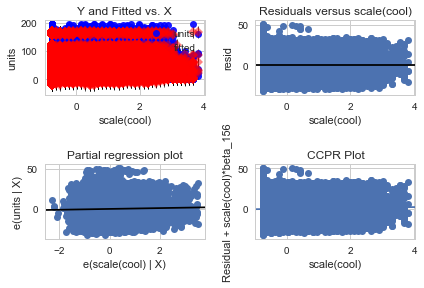

In [90]:
fig = sm.graphics.plot_regress_exog(result, "scale(cool)")
fig.suptitle("")
plt.show()

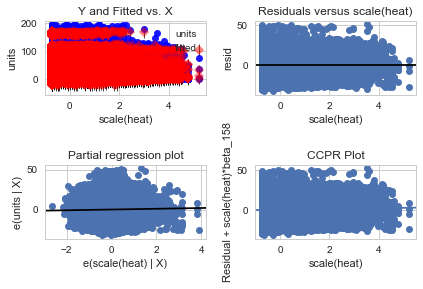

In [91]:
fig = sm.graphics.plot_regress_exog(result, "scale(heat)")
fig.suptitle("")
plt.show()

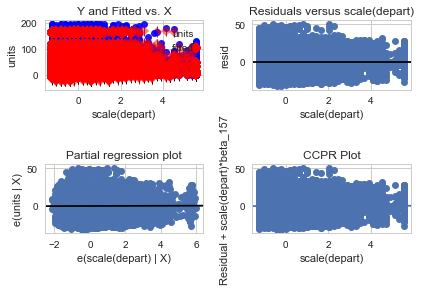

In [92]:
fig = sm.graphics.plot_regress_exog(result, "scale(depart)")
fig.suptitle("")
plt.show()

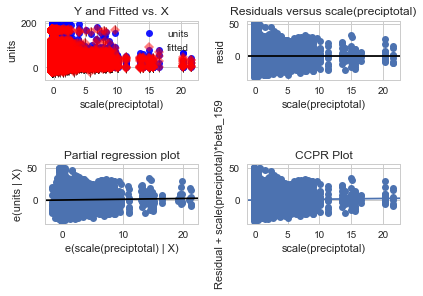

In [93]:
fig = sm.graphics.plot_regress_exog(result, "scale(preciptotal)")
fig.suptitle("")
plt.show()

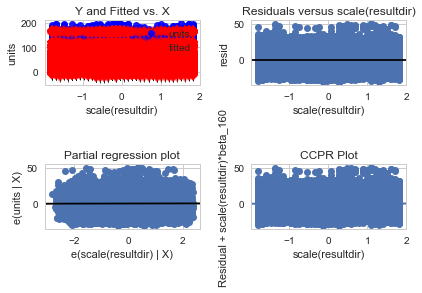

In [94]:
fig = sm.graphics.plot_regress_exog(result, "scale(resultdir)")
fig.suptitle("")
plt.show()

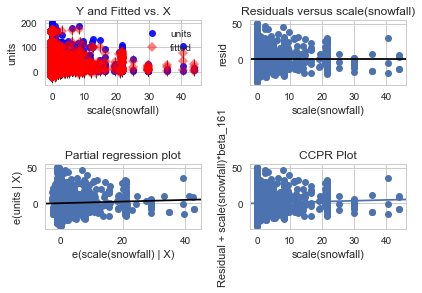

In [95]:
fig = sm.graphics.plot_regress_exog(result, "scale(snowfall)")
fig.suptitle("")
plt.show()

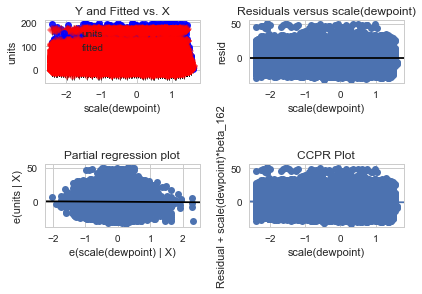

In [96]:
fig = sm.graphics.plot_regress_exog(result, "scale(dewpoint)")
fig.suptitle("")
plt.show()

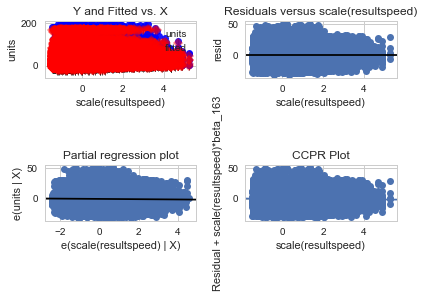

In [97]:
fig = sm.graphics.plot_regress_exog(result, "scale(resultspeed)")
fig.suptitle("")
plt.show()

### 3. 1. 6. Only Categorial Variables as features

In [98]:
formula = 'units ~ C(store_nbr) + C(item_nbr)'
model = sm.OLS.from_formula(formula,data=tmp)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  units   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     4007.
Date:                Wed, 14 Mar 2018   Prob (F-statistic):               0.00
Time:                        23:41:21   Log-Likelihood:            -3.8213e+05
No. Observations:              100432   AIC:                         7.646e+05
Df Residuals:                  100277   BIC:                         7.660e+05
Df Model:                         154                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              8.2133      0.776     10.577      0.000       6.691       9.735
C(store_nbr)[T.2]     30.0635      0.485     61.976      0.000      29.113      31.014
C(store_nbr)[T.3]     15.8454      0.444     35.664      0.000      14.975      16.716
C(store_nbr)[T.4]     71.2127      0.651    109.441      0.000      69.937      72.488
C(store_nbr)[T.5]     11.4044      0.459     24.848      0.000      10.505      12.304
C(store_nbr)[T.6]     13.9213      0.450     30.963      0.000      13.040      14.803
C(store_nbr)[T.7]     21.6927      0.500     43.363      0.000      20.712      22.673
C(store_nbr)[T.8]      5.9953      0.476     12.587      0.000       5.062       6.929
C(store_nbr)[T.9]     16.2225      0.445     36.471      0.000      15.351      17.094
C(store_nbr)[T.10]    15.8402      0.445     35.560      0.000      14.967      16.713
C(store_nbr)[T.11]    10.6159      0.435     24.386      0.000       9.763      11.469
C(store_nbr)[T.12]    17.0957      0.456     37.497      0.000      16.202      17.989
C(store_nbr)[T.13]    30.3659      0.485     62.651      0.000      29.416      31.316
C(store_nbr)[T.14]   -26.6954      0.501    -53.293      0.000     -27.677     -25.714
C(store_nbr)[T.15]    20.6157      0.436     47.248      0.000      19.761      21.471
C(store_nbr)[T.16]    24.3149      0.504     48.200      0.000      23.326      25.304
C(store_nbr)[T.17]    65.4388      0.503    130.123      0.000      64.453      66.424
C(store_nbr)[T.18]     0.2136      0.454      0.471      0.638      -0.676       1.103
C(store_nbr)[T.19]     6.2293      0.505     12.332      0.000       5.239       7.219
C(store_nbr)[T.20]    22.7008      0.508     44.703      0.000      21.705      23.696
C(store_nbr)[T.21]     5.0224      0.469     10.716      0.000       4.104       5.941
C(store_nbr)[T.22]    13.0393      0.436     29.877      0.000      12.184      13.895
C(store_nbr)[T.23]    -4.7763      0.441    -10.829      0.000      -5.641      -3.912
C(store_nbr)[T.24]    72.7444      1.682     43.253      0.000      69.448      76.041
C(store_nbr)[T.25]    29.6654      0.443     67.012      0.000      28.798      30.533
C(store_nbr)[T.26]     4.1385      0.444      9.317      0.000       3.268       5.009
C(store_nbr)[T.27]     7.2851      0.424     17.193      0.000       6.455       8.116
C(store_nbr)[T.28]     2.5630      0.447      5.733      0.000       1.687       3.439
C(store_nbr)[T.29]    13.3072      0.481     27.677      0.000      12.365      14.250
C(store_nbr)[T.30]    21.2541      0.511     41.611      0.000      20.253      22.255
C(store_nbr)[T.31]    24.0227      0.430     55.911      0.000      23.181      24.865
C(store_nbr)[T.32]     3.5490      0.406      8.734      0.000       2.753       4.345
C(store_nbr)[T.33]    88.9276      0.5

# 3. 2. OLS : Second Approach

$$ \text{units} = \text{cat}_1 + \text{cat}_2 + \text{cat}_1 + \cdot\cdot\cdot + \text{cat}_i$$

In [99]:
tmp2 = df_test.copy()

In [100]:
print(tmp2.shape)
tmp2.head()

(118664, 31)


,store_nbr,station_nbr,date,item_nbr,units,tmax,tmin,tavg,depart,dewpoint,...,avgspeed,year,month,day,monthday,days,dayofweek,weekend_YN,codesum_YN,codesum
8,1,1,2012-01-01,9,29,52.0,31.0,42.0,10.0,36.0,...,4.6,2012,1,1,"[01, 01]",1,Sun,weekend,1,"BR,RA"
27,1,1,2012-01-01,28,2,52.0,31.0,42.0,10.0,36.0,...,4.6,2012,1,1,"[01, 01]",1,Sun,weekend,1,"BR,RA"
50,1,1,2012-01-01,51,1,52.0,31.0,42.0,10.0,36.0,...,4.6,2012,1,1,"[01, 01]",1,Sun,weekend,1,"BR,RA"
119,1,1,2012-01-02,9,60,50.0,31.0,41.0,23.0,26.0,...,10.3,2012,1,2,"[01, 02]",2,Mon,workday,0,AN
138,1,1,2012-01-02,28,5,50.0,31.0,41.0,23.0,26.0,...,10.3,2012,1,2,"[01, 02]",2,Mon,workday,0,AN


### 3. 2. 1. OLS

In [101]:
formula = ('np.log(units) ~ C(store_nbr) + C(item_nbr) + C(day) + C(dayofweek) + C(codesum)')
model = sm.OLS.from_formula(formula, data=tmp2)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(units)   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     3657.
Date:                Wed, 14 Mar 2018   Prob (F-statistic):               0.00
Time:                        23:41:31   Log-Likelihood:            -1.0604e+05
No. Observations:              118664   AIC:                         2.125e+05
Df Residuals:                  118470   BIC:                         2.143e+05
Df Model:                         193                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.8316    

### 3. 2. 2.  `codesum` modification
- BR, RA 코드는 p-value 높게 나옴
- RA로 변경

In [102]:
def convert_codesum2(codesum):
    if codesum == "BR,RA":
        return "RA"
    else:
        return codesum

In [103]:
tmp2['codesum'] = tmp2['codesum'].apply(convert_codesum2)

In [104]:
formula = ('np.log(units) ~ C(store_nbr) + C(item_nbr) + C(day) + C(dayofweek) + C(codesum)')
model = sm.OLS.from_formula(formula, data= tmp2)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(units)   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     3675.
Date:                Wed, 14 Mar 2018   Prob (F-statistic):               0.00
Time:                        23:41:40   Log-Likelihood:            -1.0605e+05
No. Observations:              118664   AIC:                         2.125e+05
Df Residuals:                  118471   BIC:                         2.144e+05
Df Model:                         192                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.8317    

### 3. 2. 3 Eliminate Outlier 

In [105]:
res = result.resid_pearson
index = result.resid.index
outlier_index = abs(res) >= 2

row = pd.Series(index=index, data=res)
drop_index = row[outlier_index].index
len(drop_index)

tmp2.drop(list(drop_index),inplace=True)
tmp2.reset_index(drop = True, inplace = True)
len(tmp2)

112783

In [106]:
formula = ('np.log(units) ~ C(store_nbr) + C(item_nbr) + C(day) + C(dayofweek) + C(codesum)')
model = sm.OLS.from_formula(formula, data= tmp2)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(units)   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     5814.
Date:                Wed, 14 Mar 2018   Prob (F-statistic):               0.00
Time:                        23:41:48   Log-Likelihood:                -74514.
No. Observations:              112783   AIC:                         1.494e+05
Df Residuals:                  112590   BIC:                         1.513e+05
Df Model:                         192                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.7883    

### 3. 2. 4 Cross Validation with Sci-kit Learn

In [107]:
from patsy import dmatrices
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

#### 3. 2. 4. 1. Convert stringtype data into digits for CV

In [108]:
def convert_dayofweek(dow):
    if dow == "Mon":
        return 1
    if dow == "Tue":
        return 2
    if dow == "Wed":
        return 3
    if dow == "Thi":
        return 4
    if dow == "Fri":
        return 5
    if dow == "Sat":
        return 6
    if dow == "Sun":
        return 7
    
def convert_weekend(weekend):
    if weekend == "weekend":
        return 0
    if weekend == "workday":
        return 1

def convert_codesum(codesum):
    if codesum == "AN":
        return 0
    if codesum == "MO":
        return 1
    if codesum == "RA":
        return 2
    if codesum == "BR":
        return 3
    
tmp2['dayofweek'] = tmp2['dayofweek'].apply(convert_dayofweek)
tmp2['weekend_YN'] = tmp2['weekend_YN'].apply(convert_weekend)
tmp2['codesum'] = tmp2['codesum'].apply(convert_codesum)

In [109]:
tmp2

,store_nbr,station_nbr,date,item_nbr,units,tmax,tmin,tavg,depart,dewpoint,...,avgspeed,year,month,day,monthday,days,dayofweek,weekend_YN,codesum_YN,codesum
0,1,1,2012-01-01,9,29,52.0,31.0,42.0,10.0,36.0,...,4.6,2012,1,1,"[01, 01]",1,7,0,1,2
1,1,1,2012-01-01,28,2,52.0,31.0,42.0,10.0,36.0,...,4.6,2012,1,1,"[01, 01]",1,7,0,1,2
2,1,1,2012-01-01,51,1,52.0,31.0,42.0,10.0,36.0,...,4.6,2012,1,1,"[01, 01]",1,7,0,1,2
3,1,1,2012-01-02,9,60,50.0,31.0,41.0,23.0,26.0,...,10.3,2012,1,2,"[01, 02]",2,1,1,0,0
4,1,1,2012-01-02,28,5,50.0,31.0,41.0,23.0,26.0,...,10.3,2012,1,2,"[01, 02]",2,1,1,0,0
5,1,1,2012-01-02,51,1,50.0,31.0,41.0,23.0,26.0,...,10.3,2012,1,2,"[01, 02]",2,1,1,0,0
6,1,1,2012-01-03,9,15,32.0,11.0,22.0,2.0,4.0,...,11.6,2012,1,3,"[01, 03]",3,2,1,0,0
7,1,1,2012-01-03,28,9,32.0,11.0,22.0,2.0,4.0,...,11.6,2012,1,3,"[01, 03]",3,2,1,0,0
8,1,1,2012-01-04,9,20,28.0,9.0,19.0,15.0,1.0,...,8.3,2012,1,4,"[01, 04]",4,3,1,0,0
9,1,1,2012-01-04,28,3,28.0,9.0,19.0,15.0,1.0,...,8.3,2012,1,4,"[01, 04]",4,3,1,0,0


#### 3. 2. 4. 2. Apply Regularization (Ridge, Lasso, Elastic-Net)

In [110]:
y, X = dmatrices('np.log(units) ~ C(store_nbr) + C(item_nbr) + C(day) +C(dayofweek) +C(codesum)', tmp2, return_type = 'dataframe')

model_LR = LinearRegression().fit(X, y)
model_ridge = Ridge(alpha = 0.01).fit(X, y)
model_lasso = Lasso(alpha = 0.01).fit(X, y)
model_EN = ElasticNet(alpha = 0.01).fit(X, y)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [111]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

cv = KFold(10, shuffle=True)
print('Linear Regression Model')
print('mean : ', np.mean(cross_val_score(model_LR, X, y, scoring="r2", cv=cv)),'\n')

print('Ridge Regularized Model')
print('mean : ', np.mean(cross_val_score(model_LR, X, y, scoring="r2", cv=cv)),'\n')

print('Lasso Regularized Model')
print('mean : ', np.mean(cross_val_score(model_LR, X, y, scoring="r2", cv=cv)),'\n')

print('Elastic Net Regularzied Model')
print('mean : ', np.mean(cross_val_score(model_LR, X, y, scoring="r2", cv=cv)),'\n')

Linear Regression Model
mean :  0.908007290172 

Ridge Regularized Model
mean :  0.907966869798 

Lasso Regularized Model
mean :  0.907995169785 

Elastic Net Regularzied Model
mean :  0.907989317658 



### (_Select Ridge regulared model _)

-------------------------------------------

# 4. Predict model on test data

#### Load, merge weather data

In [157]:
test = pd.read_csv('./data/test.csv', index_col = 0)
test.reset_index(inplace = True)
print(test.shape)
test.tail()

(526917, 3)


,date,store_nbr,item_nbr
526912,2014-10-26,45,107
526913,2014-10-26,45,108
526914,2014-10-26,45,109
526915,2014-10-26,45,110
526916,2014-10-26,45,111


In [158]:
test_X = test.merge(keys).merge(weather)
print(test_X.shape)
test_X.tail()

(526917, 30)


,date,store_nbr,item_nbr,station_nbr,tmax,tmin,tavg,depart,dewpoint,wetbulb,...,avgspeed,year,month,day,monthday,days,dayofweek,weekend_YN,codesum_YN,codesum
526912,2014-08-02,40,107,13,81.0,51.0,66.0,3.0,47.0,56.0,...,6.5,2014,8,2,"[08, 02]",214,Sat,weekend,0,AN
526913,2014-08-02,40,108,13,81.0,51.0,66.0,3.0,47.0,56.0,...,6.5,2014,8,2,"[08, 02]",214,Sat,weekend,0,AN
526914,2014-08-02,40,109,13,81.0,51.0,66.0,3.0,47.0,56.0,...,6.5,2014,8,2,"[08, 02]",214,Sat,weekend,0,AN
526915,2014-08-02,40,110,13,81.0,51.0,66.0,3.0,47.0,56.0,...,6.5,2014,8,2,"[08, 02]",214,Sat,weekend,0,AN
526916,2014-08-02,40,111,13,81.0,51.0,66.0,3.0,47.0,56.0,...,6.5,2014,8,2,"[08, 02]",214,Sat,weekend,0,AN


## 4. 1. Preprocess test data for prediction

- units > 0
- features

In [159]:
test_X_model = pd.DataFrame(columns=['date','store_nbr', 'item_nbr','day','dayofweek','codesum'])

for nbr in range(1, 45+1):
    store_nbr = tmp2[tmp2['store_nbr'].isin([nbr])]
    sold_item_list = list(store_nbr['item_nbr'].unique())
    sold_item_list

    test_store_nbr = test_X[test_X['store_nbr'].isin([nbr])]
    to_test_df = test_store_nbr[test_store_nbr['item_nbr'].isin(sold_item_list)]

    test_X_model = pd.concat([test_X_model, to_test_df], axis = 0)
    
test_X_model.reset_index(drop=True, inplace=True)

In [160]:
print(test_X_model.shape)
test_X_model.head()

(26168, 30)


,avgspeed,codesum,codesum_YN,cool,date,day,dayofweek,days,depart,dewpoint,...,stnpressure,store_nbr,sunrise,sunset,tavg,tmax,tmin,weekend_YN,wetbulb,year
0,8.0,AN,0.0,0.0,2013-06-04,4,Tue,155.0,9.0,42.0,...,29.77,1,385.0,1087.0,62.0,70.0,53.0,workday,52.0,2013.0
1,8.0,AN,0.0,0.0,2013-06-04,4,Tue,155.0,9.0,42.0,...,29.77,1,385.0,1087.0,62.0,70.0,53.0,workday,52.0,2013.0
2,8.0,AN,0.0,0.0,2013-06-04,4,Tue,155.0,9.0,42.0,...,29.77,1,385.0,1087.0,62.0,70.0,53.0,workday,52.0,2013.0
3,8.0,AN,0.0,0.0,2013-06-04,4,Tue,155.0,9.0,42.0,...,29.77,1,385.0,1087.0,62.0,70.0,53.0,workday,52.0,2013.0
4,8.0,AN,0.0,0.0,2013-06-04,4,Tue,155.0,9.0,42.0,...,29.77,1,385.0,1087.0,62.0,70.0,53.0,workday,52.0,2013.0


In [161]:
test_X_model['dayofweek'] = test_X_model['dayofweek'].apply(convert_dayofweek)
test_X_model['holiday'] = test_X_model['weekend_YN'].apply(convert_weekend)
test_X_model['codesum'] = test_X_model['codesum'].apply(convert_codesum)

In [162]:
test_X_model

,avgspeed,codesum,codesum_YN,cool,date,day,dayofweek,days,depart,dewpoint,...,store_nbr,sunrise,sunset,tavg,tmax,tmin,weekend_YN,wetbulb,year,holiday
0,8.0,0.0,0.0,0.0,2013-06-04,4,2,155.0,9.0,42.0,...,1,385.0,1087.0,62.0,70.0,53.0,workday,52.0,2013.0,1
1,8.0,0.0,0.0,0.0,2013-06-04,4,2,155.0,9.0,42.0,...,1,385.0,1087.0,62.0,70.0,53.0,workday,52.0,2013.0,1
2,8.0,0.0,0.0,0.0,2013-06-04,4,2,155.0,9.0,42.0,...,1,385.0,1087.0,62.0,70.0,53.0,workday,52.0,2013.0,1
3,8.0,0.0,0.0,0.0,2013-06-04,4,2,155.0,9.0,42.0,...,1,385.0,1087.0,62.0,70.0,53.0,workday,52.0,2013.0,1
4,8.0,0.0,0.0,0.0,2013-06-04,4,2,155.0,9.0,42.0,...,1,385.0,1087.0,62.0,70.0,53.0,workday,52.0,2013.0,1
5,8.0,0.0,0.0,0.0,2013-06-04,4,2,155.0,9.0,42.0,...,1,385.0,1087.0,62.0,70.0,53.0,workday,52.0,2013.0,1
6,8.0,0.0,0.0,0.0,2013-06-04,4,2,155.0,9.0,42.0,...,1,385.0,1087.0,62.0,70.0,53.0,workday,52.0,2013.0,1
7,8.0,0.0,0.0,0.0,2013-06-04,4,2,155.0,9.0,42.0,...,1,385.0,1087.0,62.0,70.0,53.0,workday,52.0,2013.0,1
8,4.8,0.0,0.0,0.0,2013-06-05,5,3,156.0,8.0,46.0,...,1,432.0,1091.0,63.0,75.0,50.0,workday,54.0,2013.0,1
9,4.8,0.0,0.0,0.0,2013-06-05,5,3,156.0,8.0,46.0,...,1,432.0,1091.0,63.0,75.0,50.0,workday,54.0,2013.0,1


In [163]:
from patsy import dmatrix
t_X = dmatrix('C(store_nbr) + C(item_nbr) +C(day) +C(dayofweek) +C(codesum)', test_X_model, return_type = 'dataframe')

## 4. 2. Check shape of test data

In [164]:
len(test_X_model['store_nbr'].unique()),len(tmp2['store_nbr'].unique())

(44, 45)

In [165]:
set(tmp2['store_nbr'].unique()) - set(test_X_model['store_nbr'].unique())

{35}

- **store_nbr 35 가 test 데이터에는 없음을 확인.**
- **누락된 store_nbr 제외 후 모델 재생성**

## 4. 3. Regenerate Model

In [166]:
train_data = df_test.copy()
train_data = train_data[train_data['units'] != 0]
train_data.reset_index(drop = True).tail()

train_data['codesum'] = train_data['codesum'].apply(convert_codesum2)
train_data['dayofweek'] = train_data['dayofweek'].apply(convert_dayofweek)
train_data['weekend_YN'] = train_data['weekend_YN'].apply(convert_weekend)
train_data['codesum'] = train_data['codesum'].apply(convert_codesum)
train_data.tail()

,store_nbr,station_nbr,date,item_nbr,units,tmax,tmin,tavg,depart,dewpoint,...,avgspeed,year,month,day,monthday,days,dayofweek,weekend_YN,codesum_YN,codesum
4616378,39,8,2014-10-30,111,3,82.0,59.0,71.0,16.0,60.0,...,0.2,2014,10,30,"[10, 30]",303,4,1,1,0
4616387,39,8,2014-10-31,9,12,78.0,55.0,67.0,10.0,61.0,...,5.1,2014,10,31,"[10, 31]",304,5,1,1,2
4616414,39,8,2014-10-31,36,3,78.0,55.0,67.0,10.0,61.0,...,5.1,2014,10,31,"[10, 31]",304,5,1,1,2
4616481,39,8,2014-10-31,103,4,78.0,55.0,67.0,10.0,61.0,...,5.1,2014,10,31,"[10, 31]",304,5,1,1,2
4616489,39,8,2014-10-31,111,2,78.0,55.0,67.0,10.0,61.0,...,5.1,2014,10,31,"[10, 31]",304,5,1,1,2


### 4. 3. 1. Drop `store_nbr 35`

In [167]:
drop_list = list(train_data[train_data['store_nbr'].isin([35])].index)
train_data.drop(index = drop_list,axis = 0,inplace = True)
len(train_data)

116071

### 4. 3. 2. Repeat step _3. 2._
### 4. 3. 3. Eliminate Outliers multiple times to increase $R^2$

In [168]:
formula = ('np.log(units) ~ C(store_nbr) + C(item_nbr) + C(day) + C(dayofweek) +C(codesum)')
model = sm.OLS.from_formula(formula, data= train_data)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(units)   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     3733.
Date:                Wed, 14 Mar 2018   Prob (F-statistic):               0.00
Time:                        23:50:36   Log-Likelihood:            -1.0356e+05
No. Observations:              116071   AIC:                         2.075e+05
Df Residuals:                  115882   BIC:                         2.093e+05
Df Model:                         188                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.9022      0

In [169]:
res = result.resid_pearson
index = result.resid.index
outlier_index = abs(res) >= 2
row = pd.Series(index=index, data=res)
drop_index = row[outlier_index].index

len(drop_index)
train_data.drop(list(drop_index),inplace=True)
train_data.reset_index(drop = True, inplace = True)

In [170]:
y, X = dmatrices('np.log(units) ~ C(store_nbr) + C(item_nbr) + C(day) +C(dayofweek) +C(codesum)', train_data, return_type = 'dataframe')

model_ridge = Ridge(alpha = 0.01).fit(X, y)

## 4. 4. Predict  $\;\; \hat{y}$ 

In [171]:
y_hat = model_ridge.predict(t_X)

In [172]:
y_hat

array([[ 3.34133367],
       [ 1.53636444],
       [ 0.33410985],
       ..., 
       [ 1.38189907],
       [ 0.30662125],
       [ 0.18612476]])

### Inverse log on $log\hat{y}$

In [173]:
test_result = np.e ** y_hat
len(test_result)

18136

In [174]:
y = test_X.loc[:,['date','store_nbr','item_nbr']]
y.head()

,date,store_nbr,item_nbr
0,2013-04-01,2,1
1,2013-04-01,2,2
2,2013-04-01,2,3
3,2013-04-01,2,4
4,2013-04-01,2,5


## 4. 5. Concat predicted $\hat{y}$ on test data

In [175]:
len(test_X_model)

26168

In [176]:
test_X_model['units'] = test_result
test_X_model['units'] = test_X_model['units'].astype(int)
test_X_model = test_X_model.loc[:,['date', 'store_nbr', 'item_nbr','units']]
test_X_model.head()

ValueError: Length of values does not match length of index

In [ ]:
final_test_df = y.merge(test_X_model, on = ['date','store_nbr','item_nbr'], how = 'outer')
final_test_df.head()

#### return 0 on np.nan data

In [ ]:
def itiszero(units):
    if units > 0:
        return units
    else:
        return 0

final_test_df['units'] = final_test_df['units'].apply(itiszero).astype(int)
final_test_df.head()

In [ ]:
print(test.shape)
print(final_test_df.shape)

## 4. 6. Create submission.csv

In [ ]:
final_test_df['id'] = final_test_df['store_nbr'].astype(str)+"_"+final_test_df['item_nbr'].astype(str)+'_'+final_test_df['date'].astype(str)

In [ ]:
for_submission = final_test_df.loc[:,['id','units']]
for_submission.head()

In [ ]:
for_submission.to_csv('submission_FCDSS_B_TEAM_2.csv', index = False)

<img src="data/kaggle_result.jpg">

# [ Conclusion ]